In [1]:
import sys
import os
path = os.path.abspath("lib")
sys.path.append(path)

import al_sus as al
from dyson import Sigma
import al as al_se

import pywt
import pywt.data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from matplotlib.colors import ListedColormap
import seaborn as sns

from scipy.sparse import coo_matrix

from skimage.metrics import structural_similarity as ssim

import itertools

In [39]:
# matplotlib intensity plot scale
tl_big = matplotlib.colormaps['twilight_shifted'].resampled(int(1e3))
tl_resc = ListedColormap(tl_big(np.linspace(0.075, 0.925, 10000)))

# helper function for thresholding floats
def compare(arr, thresh):
    bool_arr =  np.abs(arr)>thresh - (np.abs((np.abs(arr)-thresh)) < 1e-8)
    bool_arr = bool_arr>0
    return bool_arr

# Quantification of Compression

In [3]:
# params for compression of AL vertices

betas = np.array([10, 100, 1000])
u = 1
mu = u/2
niwf = 256

wavelet_base = "haar"
levels = np.arange(1, pywt.dwt_max_level(niwf, wavelet_base) + 1)
threshold_quantiles = np.round(np.arange(10)/100 + 0.9, 2)

In [4]:
# create dataframe to store everything

data = pd.DataFrame(
                columns=['beta', 'threshold_quantile', 'level', 'mse_spin', 'mse_charge', 'sus_spin', 'sus_charge',
                         'compression_spin', 'compression_charge', 'reconstruction_spin', 'reconstruction_charge',
                         'ssim_spin', 'ssim_charge'
                        ])

for beta_idx, beta in enumerate(betas):
    print(f"Starting calculation for beta = {beta}")
    chi_spin = al.chi_s(u, beta, mu, niwf).real
    chi_charge = al.chi_c(u, beta, mu, niwf).real

    for thresh_idx, threshold_quantile in enumerate(threshold_quantiles):
        print(f"    Calculating for threshold quantile q={threshold_quantile}")

        for level_idx, level in enumerate(levels):

            # size of approximation at each level, note: vertices have 2*niwf fermionic frequs
            a = np.int32(niwf/(2**(level-1)))

            # 2D DWT
            coeffs_c = pywt.wavedec2(chi_charge,'haar',level=level)
            coeff_c_arr, coeff_c_slices = pywt.coeffs_to_array(coeffs_c)

            coeffs_s = pywt.wavedec2(chi_spin,'haar',level=level)
            coeff_s_arr, coeff_s_slices = pywt.coeffs_to_array(coeffs_s)

            # get detail coeffs
            c_details = np.concatenate((coeff_c_arr[a:,:].flatten(), coeff_c_arr[:a,a:].flatten()))
            s_details = np.concatenate((coeff_s_arr[a:,:].flatten(), coeff_s_arr[:a,a:].flatten()))

            # compute threshold quantile wrt. to detail coeffs
            thresh_c = np.quantile(np.abs(c_details), threshold_quantile)
            thresh_s = np.quantile(np.abs(s_details), threshold_quantile)

            # truncate detail coefficients below threshold
            approx_c = np.copy(coeff_c_arr[:a,:a])
            coeff_c_arr_rec = compare(coeff_c_arr, thresh_c)*coeff_c_arr
            coeff_c_arr_rec[:a,:a] = np.copy(approx_c)

            approx_s = np.copy(coeff_s_arr[:a,:a])
            coeff_s_arr_rec = compare(coeff_s_arr, thresh_s) * coeff_s_arr
            coeff_s_arr_rec[:a,:a] = np.copy(approx_s)

            # measure compress ratio in COOrdinate format
            sp_rec_s = coo_matrix(coeff_s_arr_rec)
            sp_rec_c = coo_matrix(coeff_s_arr_rec)            
            compression_spin = 1 - (sp_rec_s.data.nbytes + sp_rec_s.row.nbytes + sp_rec_s.col.nbytes)/coeff_s_arr_rec.nbytes
            compression_charge = 1 - (sp_rec_c.data.nbytes + sp_rec_c.row.nbytes + sp_rec_c.col.nbytes)/coeff_c_arr_rec.nbytes

            # reconstruct susceptibilities and measure mse and ssim for physical susc.
            chi_charge_rec = pywt.waverec2(pywt.array_to_coeffs(coeff_c_arr_rec,coeff_c_slices,output_format='wavedec2'),'haar')
            chi_spin_rec   = pywt.waverec2(pywt.array_to_coeffs(coeff_s_arr_rec,coeff_s_slices,output_format='wavedec2'),'haar')
            
            sus_spin = np.sum(1/beta**2 * chi_spin_rec)
            sus_charge = np.sum(1/beta**2 * chi_charge_rec)

            mse_spin = np.mean(np.square(chi_spin - chi_spin_rec))
            mse_charge = np.mean(np.square(chi_charge - chi_charge_rec))
            
            ssim_spin = ssim(chi_spin, chi_spin_rec, data_range=255, gaussian_weights=True, sigma=1.5, use_sample_covariance=False)
            ssim_charge = ssim(chi_charge, chi_charge_rec, data_range=255, gaussian_weights=True, sigma=1.5, use_sample_covariance=False)
        
            # append to data
            new_data = pd.DataFrame([[beta,
                                     threshold_quantile,
                                     level,
                                     mse_spin,
                                     mse_charge,
                                     sus_spin,
                                     sus_charge,
                                     compression_spin,
                                     compression_charge,
                                     chi_spin_rec,
                                     chi_charge_rec,
                                     ssim_spin,
                                     ssim_charge]], columns=data.columns)
            
            data = pd.concat([data, new_data])            

Starting calculation for beta = 10
    Calculating for threshold quantile q=0.9
    Calculating for threshold quantile q=0.91
    Calculating for threshold quantile q=0.92
    Calculating for threshold quantile q=0.93
    Calculating for threshold quantile q=0.94
    Calculating for threshold quantile q=0.95
    Calculating for threshold quantile q=0.96
    Calculating for threshold quantile q=0.97
    Calculating for threshold quantile q=0.98
    Calculating for threshold quantile q=0.99
Starting calculation for beta = 100
    Calculating for threshold quantile q=0.9
    Calculating for threshold quantile q=0.91
    Calculating for threshold quantile q=0.92
    Calculating for threshold quantile q=0.93
    Calculating for threshold quantile q=0.94
    Calculating for threshold quantile q=0.95
    Calculating for threshold quantile q=0.96
    Calculating for threshold quantile q=0.97
    Calculating for threshold quantile q=0.98
    Calculating for threshold quantile q=0.99
Starting ca

In [5]:
# store df in pickle file
data.to_pickle("./data/ssim_cr_data.pkl")

### Plot of original susceptibility

In [6]:
# read from file
data = pd.read_pickle("./data/ssim_cr_data.pkl")

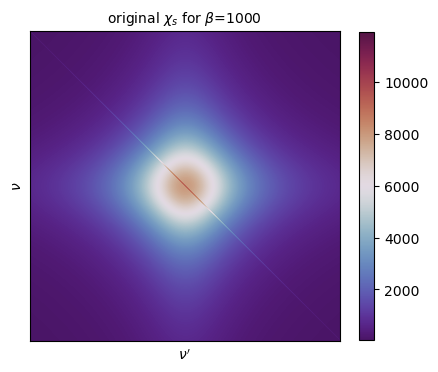

In [7]:
# compute original chi 
beta=1000
chi_spin = al.chi_s(u, beta, u/2, niwf).real

# plot
n_nus = niwf
nu_range = slice(niwf-n_nus, niwf+n_nus)
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(chi_spin[nu_range, nu_range], cmap=tl_resc)
fig.colorbar(im, ax=ax, shrink=0.8)

ax.set_xticks([]) # remove ticks
ax.set_yticks([])

ax.set_xlabel(r"$\nu'$")
ax.set_ylabel(r"$\nu$")

ax.set_title(rf"original $\chi_s$ for $\beta$={beta}", fontsize=10)

plt.savefig("graphics/compr_original.pdf", bbox_inches='tight')

### Plot of compressed susceptibility

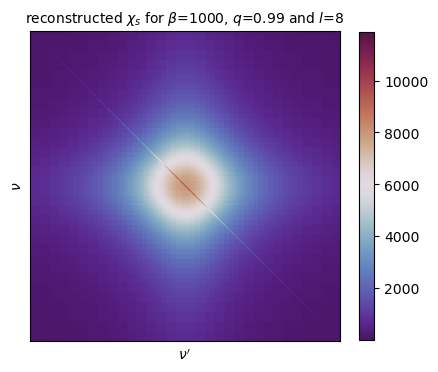

In [8]:
# pick data to plot
beta = 1000
level = levels[-1]   # max level
threshold = 0.99
pltdata = data[(data['beta']==beta) & (data['level']==level) & (data['threshold_quantile']==threshold)]['reconstruction_spin'].values[0]

# plot
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(pltdata[nu_range, nu_range], cmap=tl_resc)
fig.colorbar(im, ax=ax, shrink=0.8)

ax.set_xticks([]) # remove ticks
ax.set_yticks([])

ax.set_xlabel(r"$\nu'$") # set labels
ax.set_ylabel(r"$\nu$")

ax.set_title(rf"reconstructed $\chi_s$ for $\beta$={beta}, $q$={threshold} and $l$={level}", fontsize=10)

plt.savefig(f"graphics/compr_rec.pdf", bbox_inches='tight')

### Plot of absolute difference between original and reconstructed susceptibilities

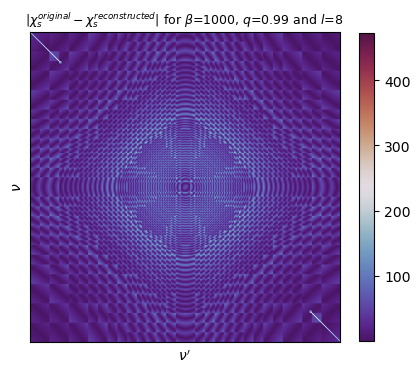

In [9]:
# plot
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(np.abs(pltdata-chi_spin)[nu_range,nu_range], cmap=tl_resc)
fig.colorbar(im, ax=ax, shrink=0.8)

ax.set_xticks([]) # remove ticks
ax.set_yticks([])

ax.set_xlabel(r"$\nu'$") # set labels
ax.set_ylabel(r"$\nu$")

ax.set_title(rf"$|\chi_s^{{original}}-\chi_s^{{reconstructed}}|$ for $\beta$={beta}, $q$={threshold} and $l$={level}", fontsize=9)

plt.savefig(f"graphics/compr_diff.pdf", bbox_inches='tight')


### Batch generation of heatmaps for CR and SSIM

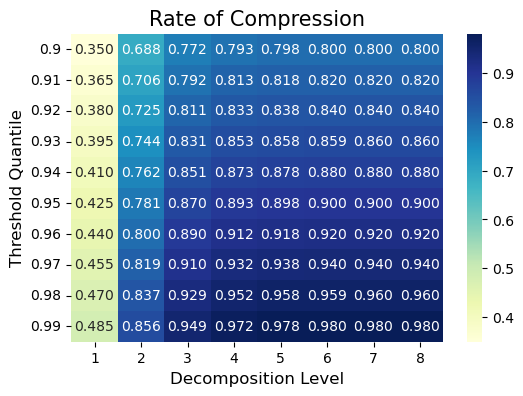

In [10]:
# test generation of one heatmap
sus = "spin"
beta = 1000
val = "compression"

heatmap_data = data[data['beta'] == beta].pivot_table(values=f'{val}_{sus}', index='threshold_quantile', columns='level')
heatmap_data.index = heatmap_data.index.set_names(['thresholdquantile'])

# plot
plt.rcParams['figure.figsize'] = 6, 4
ax = sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='.3f')
cbar = ax.collections[0].colorbar   # Get the colorbar
plt.title("Rate of Compression", fontsize=15)
plt.xlabel('Decomposition Level', fontsize=12)
plt.ylabel('Threshold Quantile', fontsize=12)
plt.savefig("graphics/CR_sus.pdf", bbox_inches='tight')
plt.show()

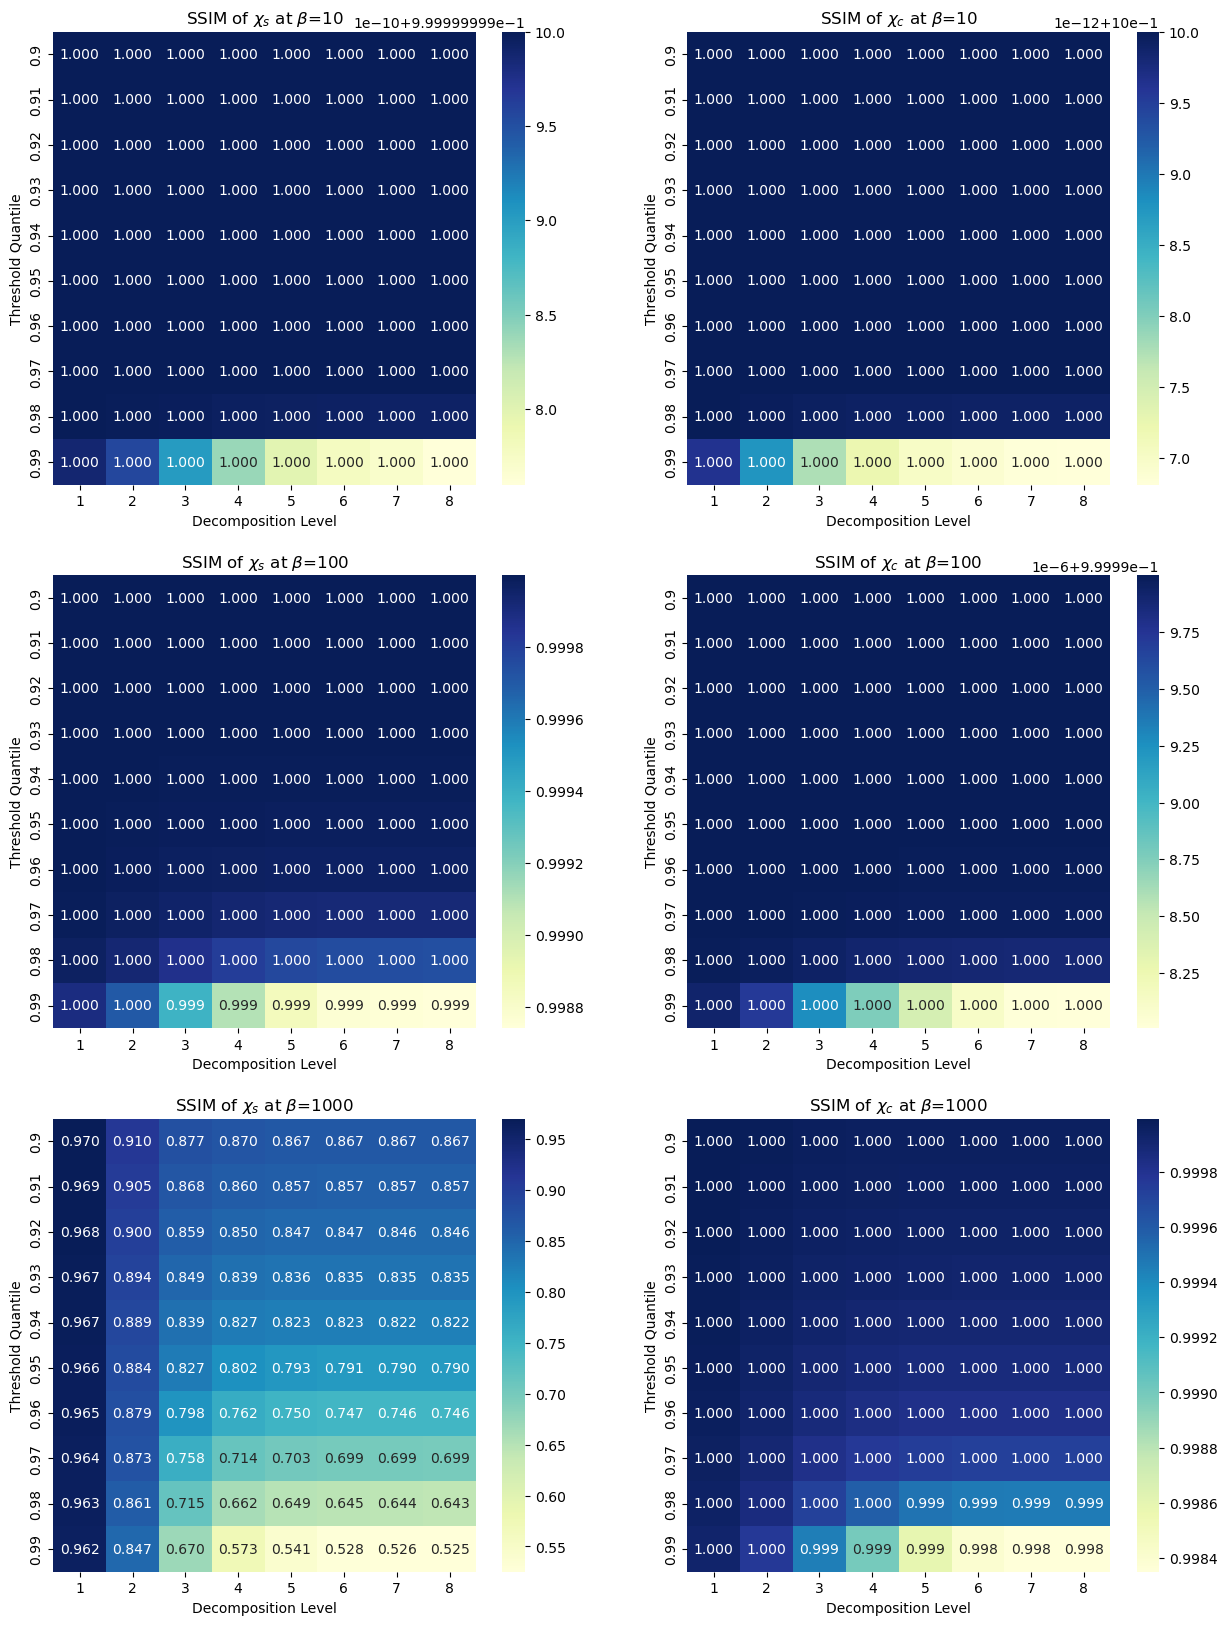

In [11]:
# make subplots for ssim
fig, axs = plt.subplots(3,2, figsize=(15,20))

for j,sus in enumerate(["spin", "charge"]):
    for i,beta in enumerate(betas):
        heatmap_data = data[data['beta'] == beta].pivot_table(values=f'ssim_{sus}', index='threshold_quantile', columns='level')
        heatmap_data.index = heatmap_data.index.set_names(['thresholdquantile'])
        ax = sns.heatmap(heatmap_data, ax=axs[i,j], annot=True, cmap='YlGnBu', fmt='.3f')
        cbar = ax.collections[0].colorbar
        axs[i,j].set_xlabel("Decomposition Level")
        axs[i,j].set_ylabel("Threshold Quantile") 
        axs[i,j].set_title(rf"SSIM of $\chi_{sus[0]}$ at $\beta$={beta}")

plt.savefig("graphics/ssim_all.pdf", bbox_inches='tight')

# Spin vs Charge Susceptibility

In [12]:
# plotting settings

import scienceplots
plt.style.use(['science', 'no-latex'])
SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['lines.markersize'] = 8

In [13]:
# params
betas = np.logspace(-2, 3, num = 20)
threshold_quantiles = np.array([0.93,0.95,0.97,0.99,1.0])
u = 1
mu = u/2
niwfs = [1024,1200]

In [14]:
# compute physical charge/spin susceptibilites and compress them
data = pd.DataFrame(
                columns=['niwf', 'beta', 'threshold_quantile', 'phys_chi_charge', 'phys_chi_spin'])

for niwf in niwfs:
    print(f"Starting Calculation for frequency size niwf={niwf}")
    level = np.min([ pywt.dwt_max_level(niwf, "haar")])
    for beta_idx, beta in enumerate(betas, start=1):
        print(f"    Calculating for beta value {beta_idx} / {len(betas)}")

        # compute susc.
        chi_spin = al.chi_s(u, beta, mu, niwf).real
        chi_spin_phys = np.sum(chi_spin)/beta**2
        chi_charge = al.chi_c(u, beta, mu, niwf).real
        chi_charge_phys = np.sum(chi_charge)/beta**2

        # save uncompressed original susc.
        new_data = pd.DataFrame([[niwf,
                                  beta,
                                  0,
                                  chi_charge_phys,
                                  chi_spin_phys]], columns=data.columns)
            
        data = pd.concat([data, new_data])

        # now loop over quantiles and do compression
        for threshold_quantile in threshold_quantiles:
            # size of approximation at each level, note: vertices have 2*niwf fermionic frequs
            a = np.int32(niwf/(2**(level-1)))

            # 2D DWT
            coeffs_c = pywt.wavedec2(chi_charge,'haar',level=level)
            coeff_c_arr, coeff_c_slices = pywt.coeffs_to_array(coeffs_c)

            coeffs_s = pywt.wavedec2(chi_spin,'haar',level=level)
            coeff_s_arr, coeff_s_slices = pywt.coeffs_to_array(coeffs_s)

            # get detail coeffs
            c_details = np.concatenate((coeff_c_arr[a:,:].flatten(), coeff_c_arr[:a,a:].flatten()))
            s_details = np.concatenate((coeff_s_arr[a:,:].flatten(), coeff_s_arr[:a,a:].flatten()))

            # compute threshold quantile wrt. to detail coeffs
            thresh_c = np.quantile(np.abs(c_details), threshold_quantile)
            thresh_s = np.quantile(np.abs(s_details), threshold_quantile)

            # truncate detail coefficients below threshold
            approx_c = np.copy(coeff_c_arr[:a,:a])
            coeff_c_arr_rec = compare(coeff_c_arr, thresh_c) * coeff_c_arr 
            coeff_c_arr_rec[:a,:a] = np.copy(approx_c)

            approx_s = np.copy(coeff_s_arr[:a,:a])
            coeff_s_arr_rec = compare(coeff_s_arr, thresh_s) * coeff_s_arr
            coeff_s_arr_rec[:a,:a] = np.copy(approx_s)

            # reconstruct susceptibilities and measure mse and ssim for physical susc.
            chi_charge_rec = pywt.waverec2(pywt.array_to_coeffs(coeff_c_arr_rec,coeff_c_slices,output_format='wavedec2'),'haar')
            chi_spin_rec   = pywt.waverec2(pywt.array_to_coeffs(coeff_s_arr_rec,coeff_s_slices,output_format='wavedec2'),'haar')
            
            sus_spin = np.sum(1/beta**2 * chi_spin_rec)
            sus_charge = np.sum(1/beta**2 * chi_charge_rec)

            new_data = pd.DataFrame([[niwf,
                                      beta,
                                      threshold_quantile,
                                      sus_charge,
                                      sus_spin]], columns=data.columns)

            data = pd.concat([data, new_data])

# store df in pickle file
data.to_pickle("./data/sc_sep_data.pkl")

Starting Calculation for frequency size niwf=1024
    Calculating for beta value 1 / 20
    Calculating for beta value 2 / 20
    Calculating for beta value 3 / 20
    Calculating for beta value 4 / 20
    Calculating for beta value 5 / 20
    Calculating for beta value 6 / 20
    Calculating for beta value 7 / 20
    Calculating for beta value 8 / 20
    Calculating for beta value 9 / 20
    Calculating for beta value 10 / 20
    Calculating for beta value 11 / 20
    Calculating for beta value 12 / 20
    Calculating for beta value 13 / 20
    Calculating for beta value 14 / 20
    Calculating for beta value 15 / 20
    Calculating for beta value 16 / 20
    Calculating for beta value 17 / 20
    Calculating for beta value 18 / 20
    Calculating for beta value 19 / 20
    Calculating for beta value 20 / 20
Starting Calculation for frequency size niwf=1200
    Calculating for beta value 1 / 20
    Calculating for beta value 2 / 20
    Calculating for beta value 3 / 20
    Calculating

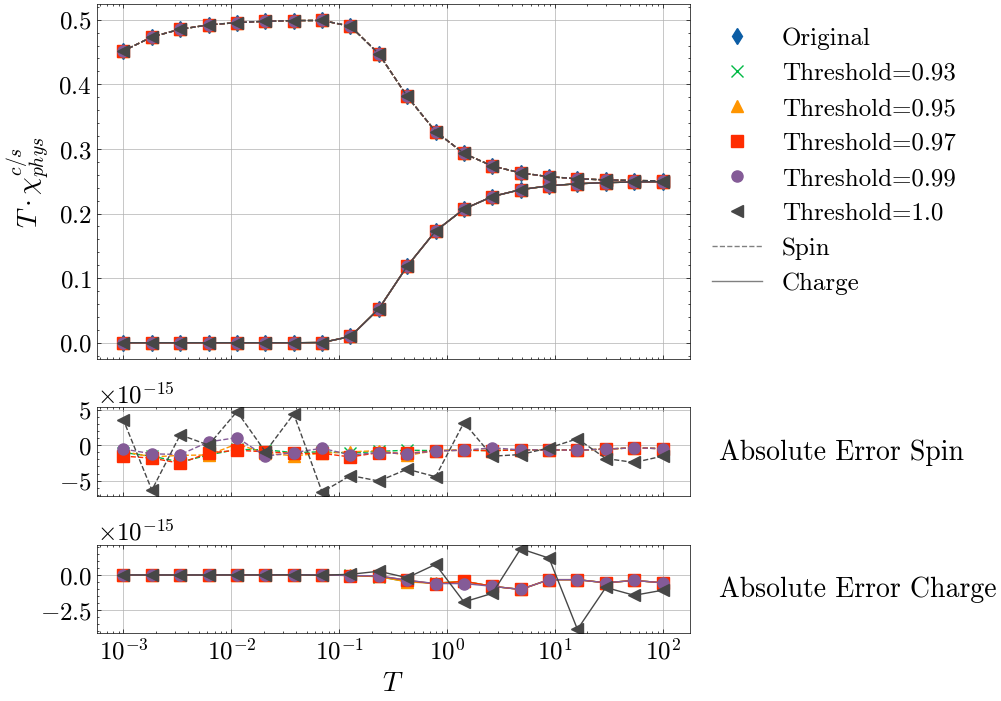

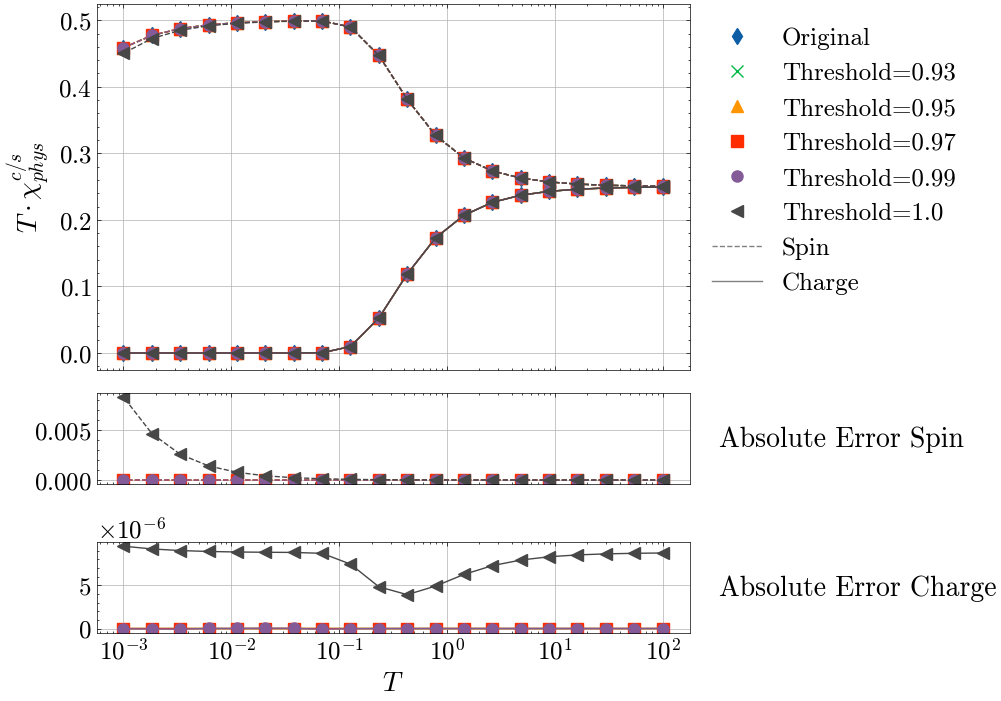

In [15]:
# read from file
df = pd.read_pickle("./data/sc_sep_data.pkl")

# Define a list of markers
markers = ['d', 'x', '^', 's', 'o', '<', '>', 'p', '*', '+']

# plot charge/spin susc.
for niwf in niwfs:
    marker_cycler = itertools.cycle(markers)
    data = df.loc[df["niwf"] == niwf].copy()
    data.loc[:, '1/beta'] = 1 / data['beta']
    data.loc[:, 'T_phys_chi_charge'] = 1/data['beta'] * data['phys_chi_charge']
    data.loc[:, 'T_phys_chi_spin'] = 1/data['beta'] * data['phys_chi_spin']

    # Getting unique threshold values
    thresholds = data['threshold_quantile'].unique()

    # Create a new figure with three subplots, the top one being larger
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 7), 
                                        gridspec_kw={'height_ratios': [4, 1, 1], 'hspace': 0.1}, 
                                        sharex=True, constrained_layout=True)

    # Extract the original data
    original_data = data[data['threshold_quantile'] == 0]
    orig_charge = original_data['T_phys_chi_charge'].values
    orig_spin = original_data['T_phys_chi_spin'].values

    # Looping over the unique threshold values
    for threshold in thresholds:
        temp_df = data[data['threshold_quantile'] == threshold]
        color = next(ax1._get_lines.prop_cycler)['color']
        marker = next(marker_cycler)

        # Plotting T_phys_chi_charge on ax1
        ax1.plot(temp_df['1/beta'], temp_df['T_phys_chi_charge'], color=color, marker=marker)

        # Plotting T_phys_chi_spin on ax1
        ax1.plot(temp_df['1/beta'], temp_df['T_phys_chi_spin'], color=color, linestyle='--', marker=marker)

        # Add legend entries
        if threshold == 0:
            ax1.plot([], [], color=color, marker=marker, linestyle='none', label=f'Original')
        else:
            ax1.plot([], [], color=color, marker=marker, linestyle='none', label=f'Threshold={threshold}')

            # Calculate differences and plot on ax2 and ax3
            diff_charge = orig_charge - temp_df['T_phys_chi_charge'].values
            diff_spin = orig_spin - temp_df['T_phys_chi_spin'].values

            ax3.plot(temp_df['1/beta'], diff_charge, color=color, marker=marker)
            ax2.plot(temp_df['1/beta'], diff_spin, color=color, linestyle='--', marker=marker)

    # Additional legend entries for spin/charge differentiation
    ax1.plot([], [], color='grey', linestyle='--', label='Spin') 
    ax1.plot([], [], color='grey', linestyle='-', label='Charge') 

    # Labels, scaling, and grids
    ax1.set_ylabel(r'$T \cdot \chi^{c/s}_{phys}$')
    ax3.set_ylabel('Charge Diff')
    ax2.set_ylabel('Spin Diff')
    ax3.set_xlabel(r'$T$')
    
    # Adjusting the x-axis for ax2 and ax3 to be on the right side
    ax3.set_ylabel("Absolute Error Charge", rotation=0, ha='left', va='center')
    ax3.yaxis.set_label_coords(1.05,0.5)
    ax3.yaxis.tick_left()

    ax2.set_ylabel("Absolute Error Spin", rotation=0, ha='left', va='center')
    ax2.yaxis.set_label_coords(1.05,0.5)
    ax2.yaxis.tick_left()
        
    for ax in [ax1, ax2, ax3]:
        ax.set_xscale('log')
        ax.grid()

    # Adding the legend to ax1
    ax1.legend(bbox_to_anchor=(1, 1))

    # Save the plot
    plt.savefig(f'graphics/spin_charge_sep_{niwf}.pdf', bbox_inches='tight')

# Eigenvalues and Eigenvectors

### Number of Negative Eigenvalues

In [16]:
# params
niwf = 256
betas = 1 / np.linspace(0.1, 0.5, 20)
us = np.linspace(0.1, 2., 20)

# 2d array to store num of negative eigenvalues for given beta and U
num_evs_negative = np.zeros((betas.size, us.size))

# loop over beta and u
for bidx, beta in enumerate(betas):
    for uidx, u in enumerate(us):
        # compute chi
        chi_charge = al.chi_c(u, beta, u/2, niwf).real
        ws, vs = np.linalg.eigh(chi_charge)
        num_evs_negative[bidx][uidx] = np.sum(ws < 0)   # number of negative evs

In [17]:
# save array for divergence lines
np.savez("./data/div_lines", num_evs_negative, betas, us)

# test loading the file
num_evs_negative = None
npzfile = np.load("./data/div_lines.npz")
num_evs_negative = npzfile['arr_0']
betas = npzfile['arr_1']
us = npzfile['arr_2']

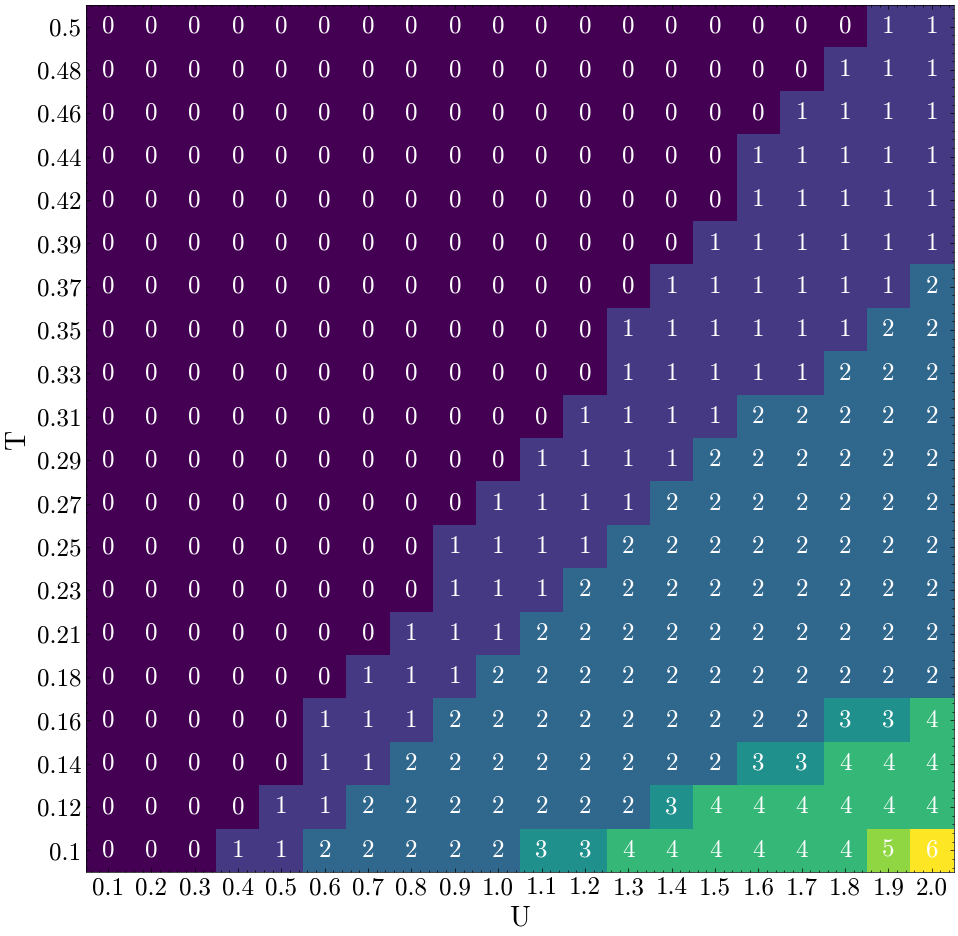

In [18]:
# plot of vertex div lines
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(num_evs_negative, origin='lower')

ax.set_xticks(np.arange(len(us)))
ax.set_yticks(np.arange(len(betas)))

ax.set_xticklabels(np.round(us, 2))
ax.set_yticklabels(np.round(1/betas, 2))

ax.set_xlabel('U')
ax.set_ylabel('T')

for i in range(len(betas)):
    for j in range(len(us)):
        text = ax.text(j, i, num_evs_negative[i, j].astype(int),
                       ha="center", va="center", color="w")

fig.tight_layout()
plt.savefig('graphics/num_negative_evs.pdf', bbox_inches='tight')

### Find first Divergence Line

In [19]:
# returns reconstructed chi after compression 
def compress(chi, level, q):
    a = np.int32(chi.shape[0]/(2**(level)))
    coeffs_c = pywt.wavedec2(chi,'haar',level=level)
    coeff_c_arr,coeff_c_slices = pywt.coeffs_to_array(coeffs_c)

    c_details = np.concatenate((coeff_c_arr[a:,:].flatten(), coeff_c_arr[:a,a:].flatten()))

    thresh_c = np.quantile(np.abs(c_details), q)

    approx_c = np.copy(coeff_c_arr[:a,:a])
    coeff_c_arr_rec = compare(coeff_c_arr, thresh_c) * coeff_c_arr 
    coeff_c_arr_rec[:a,:a] = np.copy(approx_c)

    chi_rec = pywt.waverec2(pywt.array_to_coeffs(coeff_c_arr_rec,coeff_c_slices,output_format='wavedec2'),'haar')
    
    return chi_rec


# returns rate of compression in coo format
def get_compression_ratio(chi, level, q=0.3):
    a = np.int32(chi.shape[0]/(2**(level)))
    coeffs_c = pywt.wavedec2(chi_charge,'haar',level=level)
    coeff_c_arr,coeff_c_slices = pywt.coeffs_to_array(coeffs_c)

    c_details = np.concatenate((coeff_c_arr[a:,:].flatten(), coeff_c_arr[:a,a:].flatten()))

    thresh_c = np.quantile(np.abs(c_details), q)

    approx_c = np.copy(coeff_c_arr[:a,:a])
    coeff_c_arr_rec = compare(coeff_c_arr, thresh_c) * coeff_c_arr 
    coeff_c_arr_rec[:a,:a] = np.copy(approx_c)
    
    sp_rec_c = coo_matrix(coeff_c_arr_rec)
    return 1 - (sp_rec_c.data.nbytes + sp_rec_c.row.nbytes + sp_rec_c.col.nbytes)/coeff_c_arr_rec.nbytes


# return u value where first eigenvalue changes sign
def get_lambda_zero_position(ls, Us):
    # Check if the arrays have the same length
    if len(ls) != len(Us):
        raise ValueError("The input arrays must have the same length.")
    
    # Reverse the ls array
    ls_reversed = ls[::-1]
    
    # Find the index where ls first becomes greater than zero (looking from right to left)
    greater_than_zero_indices = np.where(ls_reversed > 0)[0]
    
    # If there is no such index, raise an exception
    if len(greater_than_zero_indices) == 0:
        raise ValueError("There is no element in 'ls' greater than zero.")
    
    # Get the index of the first occurrence
    first_greater_index = greater_than_zero_indices[0]
    
    # Convert the index for the reversed array to an index for the original array
    original_index = len(ls) - 1 - first_greater_index
    
    # Return the corresponding element from Us
    return Us[original_index]

In [20]:
# find divergence line with binary search

# params
niwf = 256
beta = 1000
level = 8
threshold_quantiles = np.array([0, 0.91, 0.93, 0.95, 0.97, 0.99])

# store results
data = pd.DataFrame(
    columns=['threshold quantile', 'divergence position', 'rate of compression', 'ssim']
)

# loop through all thresholds
for t_idx, threshold_quantile in enumerate(threshold_quantiles, start=1):
    print(f"Starting binary search for threshold {t_idx} / {len(threshold_quantiles)}")

    # range for binary search
    start = 0.002
    end = 0.004
    precision = 1e-10

    # algorithm
    while (end - start) > precision:
        # generate u values
        Us = np.linspace(start, end, 3)

        # find min lambda for all Us
        l1s = np.zeros(Us.size)
        for u_idx, u in enumerate(Us):
            chi_charge = al.chi_c(u, beta, u/2, niwf).real
            if threshold_quantile==0:
                ws = np.linalg.eigvals(chi_charge)
            else:
                chi_charge_rec = compress(chi_charge, level, threshold_quantile)
                ws = np.linalg.eigvals(chi_charge_rec)
            l1s[u_idx] = np.min(ws)
        
        # find u where lambda_min switches sign
        zero_pos = get_lambda_zero_position(l1s, Us)

        # update start and end values
        range_length = (end - start) / 2
        start = zero_pos
        end = min(end, start + range_length)

    # store results
    zero = start + (end - start)/2
    if threshold_quantile==0:
        ssim_c = None
        roc = None
    else:
        u = zero
        chi_charge = al.chi_c(u, beta, u/2, niwf).real
        chi_charge_rec = compress(chi_charge, level, threshold_quantile)
        ssim_c = ssim(chi_charge, chi_charge_rec, data_range=255, gaussian_weights=True, sigma=1.5, use_sample_covariance=False)
        roc = get_compression_ratio(chi_charge, level, threshold_quantile)

    new_data = pd.DataFrame([[threshold_quantile,
                              zero,
                              roc,
                              ssim_c]], columns=data.columns)
    
    data = pd.concat([data, new_data], ignore_index=True)

Starting binary search for threshold 1 / 6
Starting binary search for threshold 2 / 6
Starting binary search for threshold 3 / 6
Starting binary search for threshold 4 / 6
Starting binary search for threshold 5 / 6
Starting binary search for threshold 6 / 6


/var/folders/f3/5mwmxdln2t587p3x9czmpc3c0000gn/T/ipykernel_1682/1322665342.py:37: ComplexWarning: Casting complex values to real discards the imaginary part
  l1s[u_idx] = np.min(ws)


In [22]:
pd.set_option("display.precision", 11)

# save df
data.to_pickle("./data/div_pos.pkl")

# show estimated divergence line for different quantiles
data

,threshold quantile,divergence position,rate of compression,ssim
0,0.00,0.00362759873,NaN,NaN
1,0.91,0.00362759873,0.81996154785,0.99999759945
2,0.93,0.00362759873,0.85993957520,0.99998910591
3,0.95,0.00362759873,0.89991760254,0.99993254485
4,0.97,0.00362759873,0.93991088867,0.99918943484
5,0.99,0.00362759873,0.97991943359,0.90104352695


In [23]:
# compare max lambda and respective weight in spin channel

# params
niwf = 256
beta = 1000
u = 1
level = 8
threshold_quantiles = np.array([0, 0.91, 0.93, 0.95, 0.97, 0.99])

# store results
data = pd.DataFrame(
    columns=['threshold quantile', 'max eigenvalue', 'max_weight', 'eigenvalue x weight', 'rate of compression', 'ssim']
)

# loop through all thresholds
for t_idx, threshold_quantile in enumerate(threshold_quantiles, start=1):
    print(f"Starting calculation for threshold {t_idx} / {len(threshold_quantiles)}")

    # compute susc
    chi_spin = al.chi_s(u, beta, u/2, niwf).real

    if threshold_quantile==0:
        ws, vs = np.linalg.eig(chi_spin)
    else:
        chi_spin_rec = compress(chi_spin, level, threshold_quantile)
        ws, vs = np.linalg.eig(chi_spin_rec)

    # find max lambda and weight
    lamb_max = np.max(ws)
    v_max = vs[:,np.argmax(ws)]
    v_inv_max = vs.T[np.argmax(ws),:]
    w_max = np.sum(v_inv_max) * np.sum(v_max)# / beta**2
    if threshold_quantile==0:
        ssim_c = None
        roc = None
    else:
        ssim_c = ssim(chi_spin, chi_spin_rec, data_range=255, gaussian_weights=True, sigma=1.5, use_sample_covariance=False)
        roc = get_compression_ratio(chi_spin, level, threshold_quantile)
    
    new_data = pd.DataFrame([[threshold_quantile,
                              lamb_max,
                              w_max,
                              lamb_max*w_max/beta**2,
                              roc,
                              ssim_c]], columns=data.columns)
    
    data = pd.concat([data, new_data], ignore_index=True)

Starting calculation for threshold 1 / 6
Starting calculation for threshold 2 / 6
Starting calculation for threshold 3 / 6
Starting calculation for threshold 4 / 6
Starting calculation for threshold 5 / 6
Starting calculation for threshold 6 / 6


In [24]:
data

,threshold quantile,max eigenvalue,max_weight,eigenvalue x weight,rate of compression,ssim
0,0.00,987605.43402920011+0.00000000000j,330.30538273923+0.00000000000j,326.21139088236+0.00000000000j,NaN,NaN
1,0.91,987577.92116142402+0.00000000000j,330.30637195128+0.00000000000j,326.20328015802+0.00000000000j,0.81996154785,0.85659762779
2,0.93,987569.83494495074+0.00000000000j,330.30790973046+0.00000000000j,326.20212789352+0.00000000000j,0.85993957520,0.83491379656
3,0.95,987553.71846298384+0.00000000000j,330.30891422781+0.00000000000j,326.19779648715+0.00000000000j,0.89991760254,0.78985046160
4,0.97,987503.10242049943+0.00000000000j,330.31183561755+0.00000000000j,326.18396243854+0.00000000000j,0.93991088867,0.69866131254
5,0.99,987246.24732986896+0.00000000000j,330.33008770563+0.00000000000j,326.11713946753+0.00000000000j,0.97991943359,0.52522164225


### Analysis of First Eigenvector

In [25]:
# params
beta = 1000
niwf = 256
level = 8	
mu = u/2   # first div line
threshold_quantiles = np.array([0.8, 0.9, 0.99])

# df to store eigenvectors
data = pd.DataFrame(
                columns=['channel', 'threshold', 'v', 'v_rec'])

for ch in ["s", "c"]:
    if ch=="s":
        u = 1
        chi = al.chi_s(u, beta, u/2, niwf).real
    else:
        u = 0.00362759873
        chi = al.chi_c(u, beta, u/2, niwf).real
    
    ws, vs = np.linalg.eig(chi)
    if ch=="s":
        v = vs[:,np.argmax(ws)]
    else:
        v = vs[:,np.argmin(ws)]

    # loop through thresholod values
    for threshold in threshold_quantiles:
        chi_rec = compress(chi, level, threshold)
        ws_rec, vs_rec = np.linalg.eig(chi_rec)
        if ch=="s":
            v_rec = vs_rec[:,np.argmax(ws_rec)]
        else:
            v_rec= vs_rec[:,np.argmin(ws_rec)]

        if np.sign(v_rec[niwf]) != np.sign(v[niwf]):
            v_rec *= -1

        new_data = pd.DataFrame([[ch,
                                threshold,
                                v,
                                v_rec]], columns=data.columns)
        
        data = pd.concat([data, new_data], ignore_index=True)

# store df in csv file
data.to_pickle("./data/v1_data.pkl")

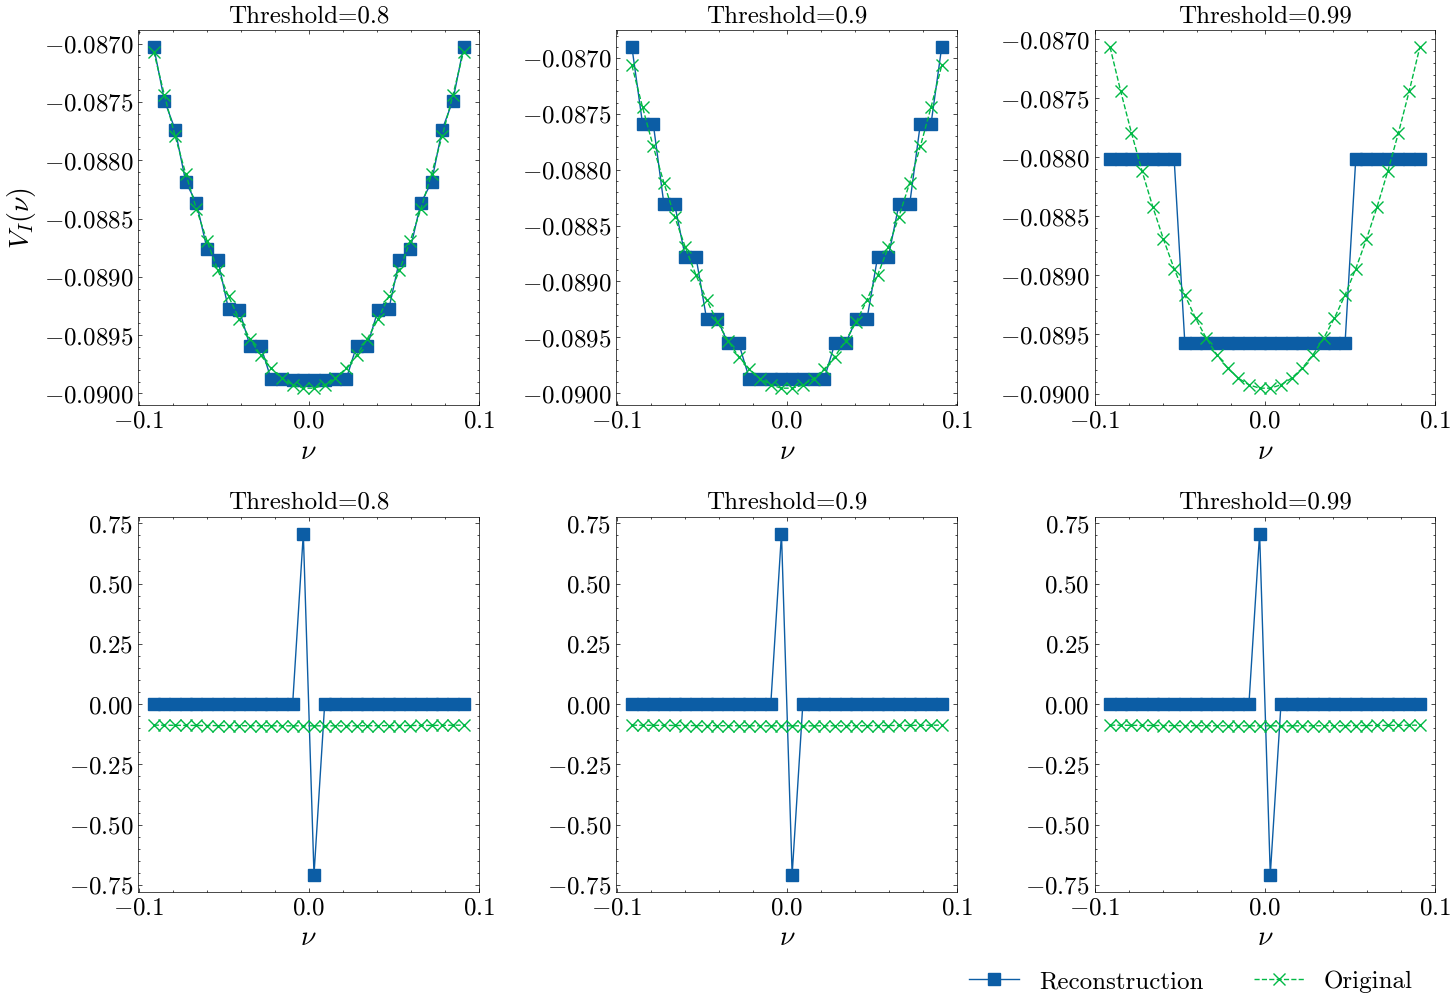

In [26]:
# test loading data
data = pd.read_pickle("./data/v1_data.pkl")

# plot of original and reconstructed EVs

fig, axs = plt.subplots(2, len(data)//2, figsize=(15, 10), sharey=False)
axs = axs.flatten()

nu_offset = 15
nu_range = slice(niwf-nu_offset, niwf+nu_offset)
nu_values = (2*np.arange(-nu_offset, nu_offset)+1)*np.pi/beta

# Loop over each row in the DataFrame
for i, row in data.iterrows():
    axs[i].plot(nu_values, row['v_rec'][nu_range].real, label=f"Reconstruction", marker='s')
    axs[i].plot(nu_values, data.iloc[0]['v'][nu_range].real, label='Original', linestyle='--', marker='x')
    axs[i].set_title(f"Threshold={row['threshold']}")
    #axs[i].xaxis.set_ticks(nu_values[nu_values % 2 == 0])
    axs[i].set_xlabel(r"$\nu$")

# Set y-label on the first subplot
axs[0].set_ylabel(r"$V_I(\nu)$")

# Adjust layout for readability
plt.tight_layout()

# Optional: Add legend to the last plot
axs[-1].legend(bbox_to_anchor=(1, -0.15), ncol=2)

plt.savefig("graphics/first_ev.pdf", bbox_inches="tight")


# Vertex Frequency Box and Wavelet Basis

In [27]:
# params
start = 32
niwfs = np.linspace(start, 512, 512-start+1)
u = 1
mu = u/2
beta = 100
threshold_quantile = 0.99

# different bases to check
waveletbases = ["haar", "sym4", "coif2", "db4", "bior4.4", "rbio4.4"]

# df to store results
data = pd.DataFrame(
    columns=["basis", "niwf", "abs_err_c", "abs_err_s", "mse_c", "mse_s", "rmse_c", "rmse_s"]
)

# loop through bases and frequency sizes
for b_idx, basis in enumerate(waveletbases, start=1):
    print(f"Starting Calculation for basis {b_idx} / {len(waveletbases)}")

    for niwf in niwfs:

        # compute original susc.
        chi_spin = al.chi_s(u, beta, mu, niwf).real
        sus_spin = np.sum(chi_spin)/beta**2
        chi_charge = al.chi_c(u, beta, mu, niwf).real
        sus_charge = np.sum(chi_charge)/beta**2

        # max level
        level = pywt.dwtn_max_level((niwf,niwf), basis)

        # size of approximation at each level, note: vertices have 2*niwf fermionic frequs
        a = np.int32(niwf/(2**(level-1)))

        # 2D DWT
        coeffs_c = pywt.wavedec2(chi_charge, basis, level=level)
        coeff_c_arr, coeff_c_slices = pywt.coeffs_to_array(coeffs_c)

        coeffs_s = pywt.wavedec2(chi_spin, basis, level=level)
        coeff_s_arr, coeff_s_slices = pywt.coeffs_to_array(coeffs_s)

        # get detail coeffs
        c_details = np.concatenate((coeff_c_arr[a:,:].flatten(), coeff_c_arr[:a,a:].flatten()))
        s_details = np.concatenate((coeff_s_arr[a:,:].flatten(), coeff_s_arr[:a,a:].flatten()))

        # compute threshold quantile wrt. to detail coeffs
        thresh_c = np.quantile(np.abs(c_details), threshold_quantile)
        thresh_s = np.quantile(np.abs(s_details), threshold_quantile)

        # truncate detail coefficients below threshold
        approx_c = np.copy(coeff_c_arr[:a,:a])
        coeff_c_arr_rec = compare(coeff_c_arr, thresh_c) * coeff_c_arr
        coeff_c_arr_rec[:a,:a] = np.copy(approx_c)

        approx_s = np.copy(coeff_s_arr[:a,:a])
        coeff_s_arr_rec = compare(coeff_s_arr, thresh_s) * coeff_s_arr
        coeff_s_arr_rec[:a,:a] = np.copy(approx_s)

        # reconstruct susceptibilities and compute physical quantities.
        chi_charge_rec = pywt.waverec2(pywt.array_to_coeffs(coeff_c_arr_rec,coeff_c_slices,output_format='wavedec2'), basis)
        chi_spin_rec   = pywt.waverec2(pywt.array_to_coeffs(coeff_s_arr_rec,coeff_s_slices,output_format='wavedec2'), basis)
        
        sus_spin_rec = np.sum(1/beta**2 * chi_spin_rec)
        sus_charge_rec = np.sum(1/beta**2 * chi_charge_rec)

        # compute error metrics
        abs_err_spin = np.abs(sus_spin - sus_spin_rec)
        abs_err_charge = np.abs(sus_charge - sus_charge_rec)

        mse_spin = np.mean(np.square(chi_spin - chi_spin_rec))
        mse_charge = np.mean(np.square(chi_charge - chi_charge_rec))

        rmse_spin = np.sqrt(mse_spin)
        rmse_charge = np.sqrt(mse_charge)

        # store results
        new_data = pd.DataFrame([[basis,
                                  niwf,
                                  abs_err_charge,
                                  abs_err_spin,
                                  mse_charge,
                                  mse_spin,
                                  rmse_charge,
                                  rmse_spin]], columns=data.columns)
        
        data = pd.concat([data, new_data], ignore_index=True)
    
data.to_pickle(f"./data/freq_box_data_q{threshold_quantile}.pkl")

Starting Calculation for basis 1 / 6
Starting Calculation for basis 2 / 6
Starting Calculation for basis 3 / 6
Starting Calculation for basis 4 / 6
Starting Calculation for basis 5 / 6
Starting Calculation for basis 6 / 6


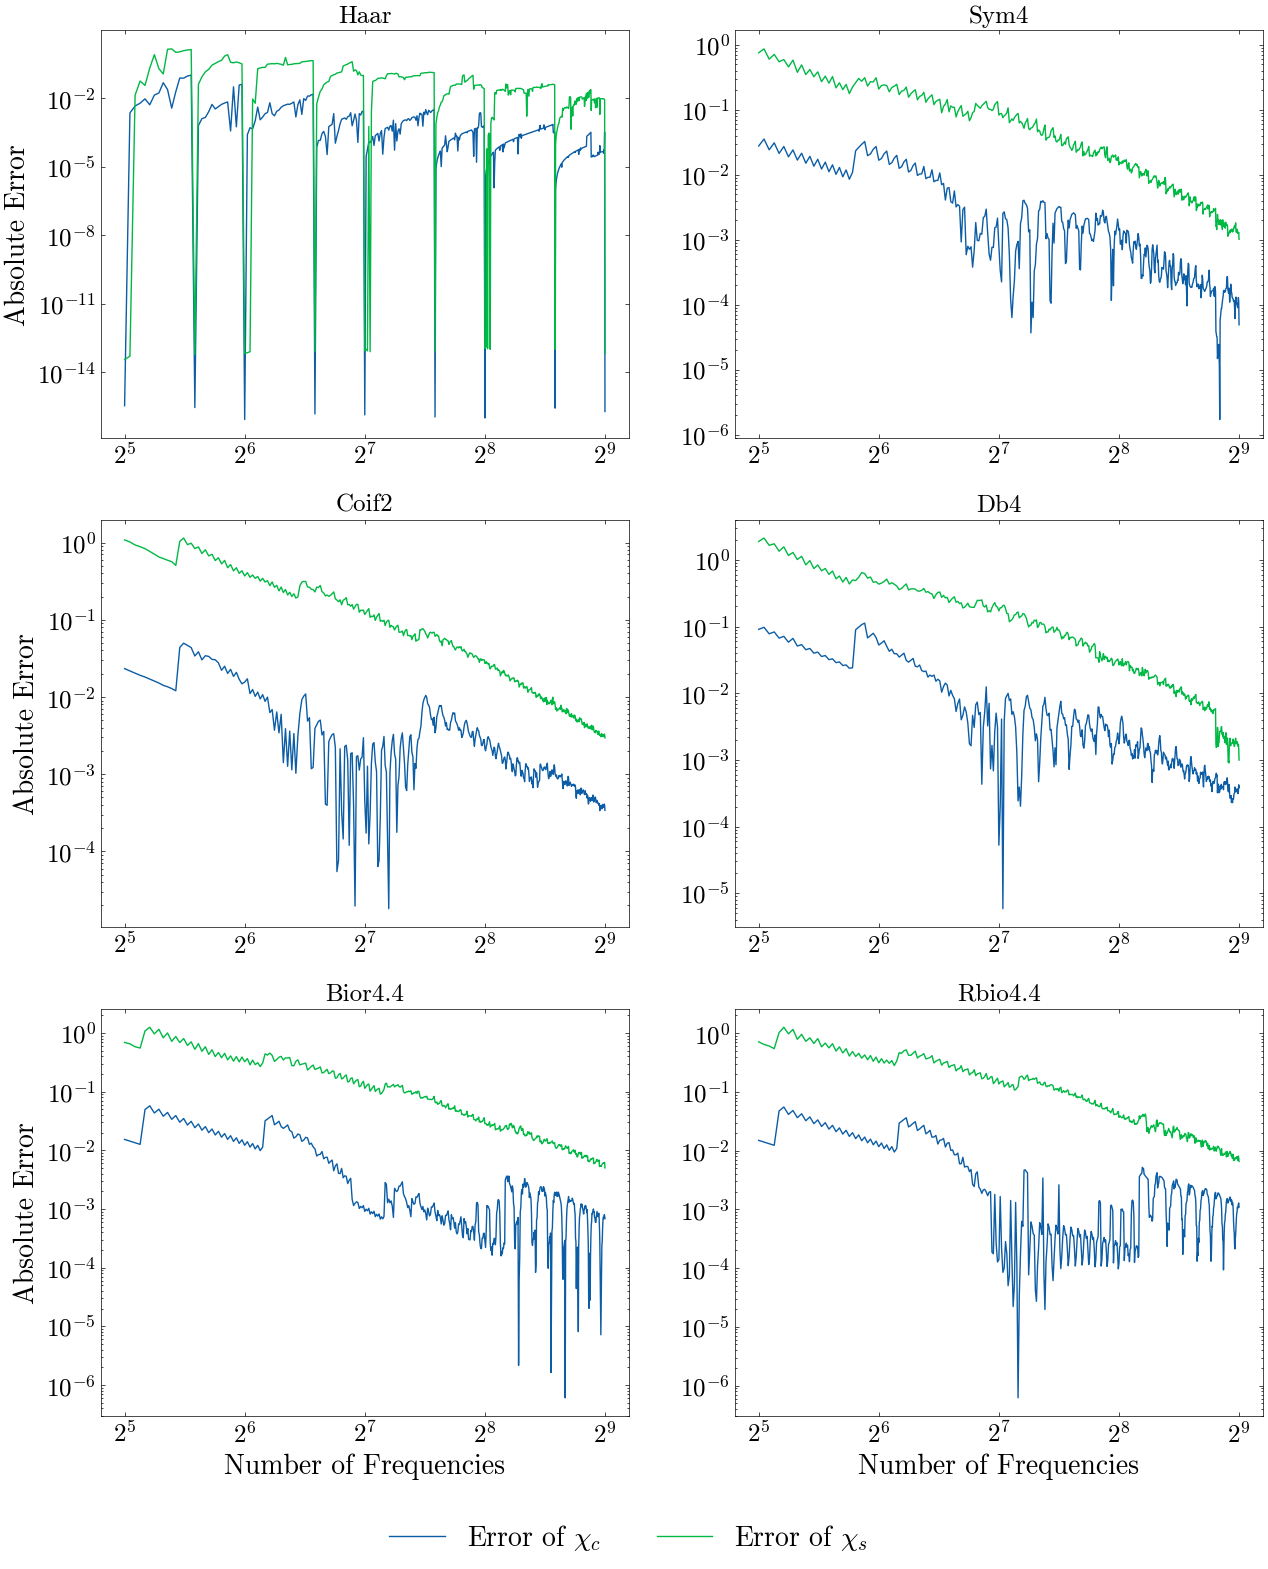

In [28]:
# load from file
data = pd.read_pickle(f"./data/freq_box_data_q{threshold_quantile}.pkl")

# plot error metrics
fig, axs = plt.subplots(3, len(waveletbases)//3, figsize=(15,18),
                        gridspec_kw={'hspace': 0.2})
axs = axs.flatten()

# metric to plot
metric = "abs_err"

# loop over the df
for b_idx, basis in enumerate(waveletbases):
    tmp_df = data.loc[data['basis']==basis]
    
    axs[b_idx].plot(tmp_df["niwf"], tmp_df[f"{metric}_c"], label=r"Error of $\chi_c$")
    axs[b_idx].plot(tmp_df["niwf"], tmp_df[f"{metric}_s"], label=r"Error of $\chi_s$")
    if b_idx%2==0:
        axs[b_idx].set_ylabel("Absolute Error")
    if b_idx==len(waveletbases)-1 or b_idx==len(waveletbases)-2:
        axs[b_idx].set_xlabel("Number of Frequencies")
    axs[b_idx].set_yscale('log')
    axs[b_idx].set_xscale('log', base=2)
    axs[b_idx].set_title(f"{basis}".capitalize())
axs[b_idx].legend(ncol=2, bbox_to_anchor=(0.3, -0.2), prop={'size':20})
plt.savefig(f"graphics/wl_bases_err_q{threshold_quantile}.pdf", bbox_inches="tight")

# Compression of G2 in SDE

### Compression along 2d slices

In [29]:
# params
niwf = 64
u = 1
mu = u/2
betas = [10, 100, 1000]
threshold_quantiles = [0, 0.9, 0.93, 0.96, 0.99, 1]
bases = ["haar", "bior6.8"]

# df to save results
data = pd.DataFrame(
    columns=["basis", "beta", "threshold_quantile", "selfenergy"]
)

for bidx, basis in enumerate(bases, start=1):
    print(f"Starting Calculation for basis {bidx} / {len(bases)}")
    for beta in betas:
        print(f"    Calculating for beta = {beta}")
        for threshold_quantile in threshold_quantiles:    
            
            # orignal SE
            atom = al_se.atom(u,beta,mu,Niwf=niwf)
            g = atom.g()
            iO = np.arange(-niwf, niwf)
            g2_ud = np.moveaxis(np.array([atom.g2ud(omega=io) for io in iO]), 0 , -1)
            #selfenergy = atom.sigma()
            selfenergy = Sigma(g, g2_ud, beta, u)
            
            if threshold_quantile==0:
                # save original SE
                zero_q_data = pd.DataFrame([[basis,
                                             beta,
                                             threshold_quantile,
                                             selfenergy]], columns=data.columns)
                
                data = pd.concat([data, zero_q_data], ignore_index=True)
            
            else:
                # DWT in 2D
                g2_ud = np.moveaxis(np.array([atom.g2ud(omega=io) for io in iO]), 0 , -1)
                G2_rec = []
                for nu in range(2*niwf):
                    coeffs_g2 = pywt.wavedec2(g2_ud[nu,:,:], basis, mode="smooth", level=pywt.dwtn_max_level(g2_ud[nu,:,:].shape, basis))
                    coeff_g2_arr, coeff_g2_slices = pywt.coeffs_to_array(coeffs_g2)

                    a = coeffs_g2[0].shape
                    g2_details = coeff_g2_arr[a[0]:,a[1]:]

                    thresh_g2 = np.quantile(np.abs(g2_details), threshold_quantile)

                    approx_g2 = np.copy(coeff_g2_arr[:a[0],:a[1]])
                    coeff_g2_arr_rec = coeff_g2_arr
                    coeff_g2_arr_rec = compare(coeff_g2_arr, thresh_g2) * coeff_g2_arr 
                    coeff_g2_arr_rec[:a[0],:a[1]] = np.copy(approx_g2)

                    g2_ud_rec = pywt.waverec2(pywt.array_to_coeffs(coeff_g2_arr_rec,coeff_g2_slices,output_format='wavedec2'),basis)

                    G2_rec.append(g2_ud_rec)

                g2_ud_rec = np.array(G2_rec)
                selfenergy = Sigma(g, g2_ud_rec, beta, u)

                new_data = pd.DataFrame([[basis,
                                          beta,
                                          threshold_quantile,
                                          selfenergy]], columns=data.columns)
                
                data = pd.concat([data, new_data], ignore_index=True)

# store df as pickle file
data.to_pickle("./data/sde_2d_data.pkl")

Starting Calculation for basis 1 / 2
    Calculating for beta = 10
    Calculating for beta = 100
    Calculating for beta = 1000
Starting Calculation for basis 2 / 2
    Calculating for beta = 10
    Calculating for beta = 100
    Calculating for beta = 1000


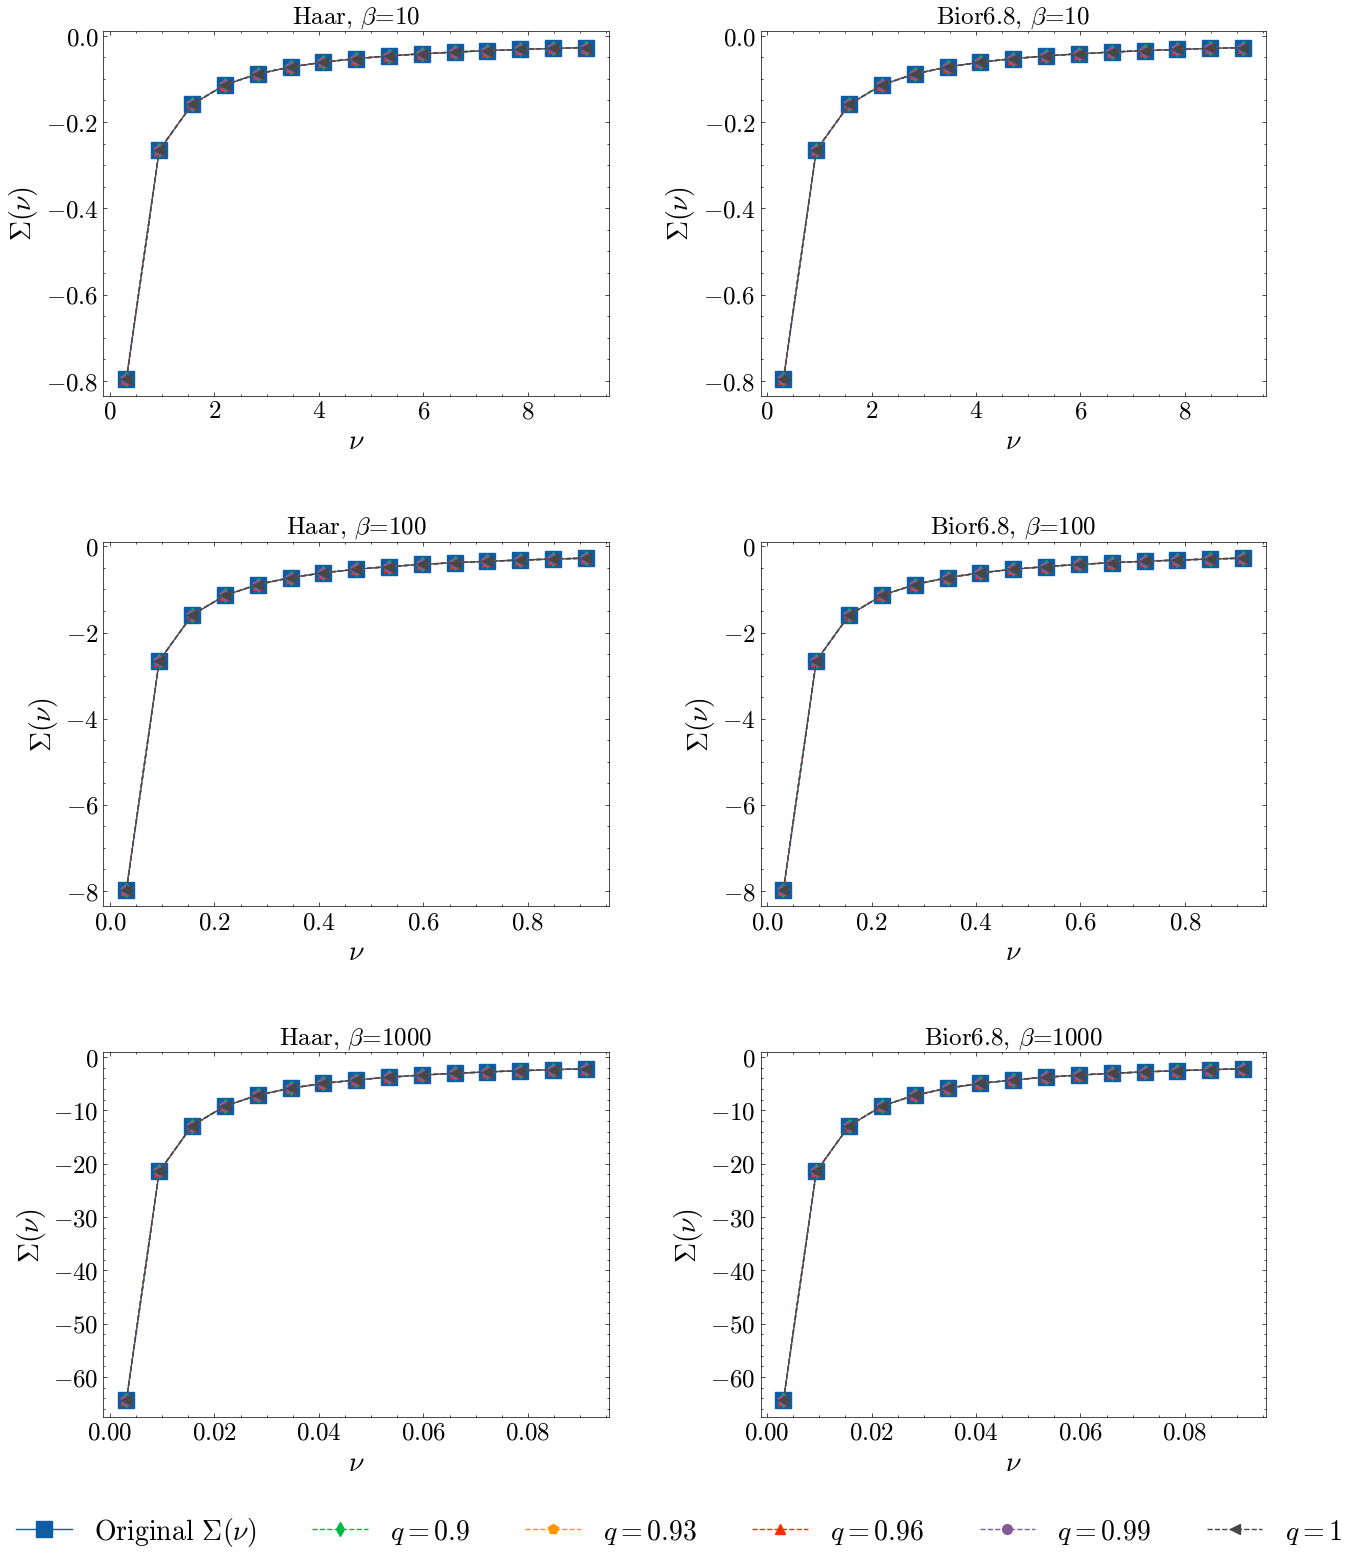

In [30]:
# plot
fig, axs = plt.subplots(3, 2, figsize=(15,18), gridspec_kw={'hspace': 0.4, 'wspace':0.3})

markers = ['s', 'd', 'p', '^', 'o', '<', '>', 'x', '*', '+']

for bidx, basis in enumerate(bases):
    for beta_idx, beta in enumerate(betas):
        for t_idx, thresh in enumerate(threshold_quantiles):
            pltdata = data.loc[(data["basis"]==basis) & (data["beta"]==beta) & (data["threshold_quantile"]==thresh)]
            niw=15
            nu = (2*np.arange(niw) + 1)*np.pi/beta
            if thresh==0:
                axs[beta_idx, bidx].plot(nu, pltdata["selfenergy"].to_numpy()[0].imag[niwf:niwf+niw], marker=markers[t_idx], ms=12, label=r"Original $\Sigma(\nu)$")
            else:
                axs[beta_idx, bidx].plot(nu, pltdata["selfenergy"].to_numpy()[0].imag[niwf:niwf+niw], marker=markers[t_idx], ls="--", ms=7, label=rf"$q=${thresh}")
            axs[beta_idx, bidx].set_xlabel(r"$\nu$")
            axs[beta_idx, bidx].set_ylabel(r"$\Sigma(\nu)$")
            axs[beta_idx, bidx].set_title(rf"{basis.capitalize()}, $\beta$={beta}")
axs[beta_idx, bidx].legend(ncol=len(threshold_quantiles), bbox_to_anchor=(1.2, -0.2), prop={'size':20})

### Compression for entire 3D G2

In [31]:
# params
niwf = 64
u = 1
mu = u/2
betas = [10, 100, 1000]
threshold_quantiles = [0, 0.9, 0.93, 0.96, 0.99, 1]
bases = ["haar", "bior6.8"]

# df to save results
data = pd.DataFrame(
    columns=["basis", "beta", "threshold_quantile", "selfenergy"]
)

for bidx, basis in enumerate(bases, start=1):
    print(f"Starting Calculation for basis {bidx} / {len(bases)}")
    for beta in betas:
        print(f"    Calculating for beta = {beta}")
        for threshold_quantile in threshold_quantiles:    
            
            # orignal SE
            atom = al_se.atom(u,beta,mu,Niwf=niwf)
            g = atom.g()
            iO = np.arange(-niwf, niwf)
            g2_ud = np.moveaxis(np.array([atom.g2ud(omega=io) for io in iO]), 0 , -1)
            #selfenergy = atom.sigma()
            selfenergy = Sigma(g, g2_ud, beta, u)
            
            if threshold_quantile==0:
                # save original SE
                zero_q_data = pd.DataFrame([[basis,
                                             beta,
                                             threshold_quantile,
                                             selfenergy]], columns=data.columns)
                
                data = pd.concat([data, zero_q_data], ignore_index=True)
            
            else:
                # DWT in 3D
                g2_ud = np.moveaxis(np.array([atom.g2ud(omega=io) for io in iO]), 0 , -1)
                coeffs_g2 = pywt.wavedecn(g2_ud, basis, mode="smooth", level=pywt.dwtn_max_level(g2_ud.shape, basis))
                coeff_g2_arr, coeff_g2_slices = pywt.coeffs_to_array(coeffs_g2)

                a = coeffs_g2[0].shape
                g2_details = coeff_g2_arr[a[0]:,a[1]:,a[2]:]

                thresh_g2 = np.quantile(np.abs(g2_details), threshold_quantile)

                approx_g2 = np.copy(coeff_g2_arr[:a[0],:a[1],:a[2]])
                coeff_g2_arr_rec = coeff_g2_arr
                coeff_g2_arr_rec = compare(coeff_g2_arr[:,:], thresh_g2)*coeff_g2_arr 
                coeff_g2_arr_rec[:a[0],:a[1],:a[2]] = np.copy(approx_g2)

                g2_ud_rec = pywt.waverecn(pywt.array_to_coeffs(coeff_g2_arr_rec,coeff_g2_slices,output_format='wavedecn'),basis)
                selfenergy = Sigma(g, g2_ud_rec, beta, u)

                new_data = pd.DataFrame([[basis,
                                          beta,
                                          threshold_quantile,
                                          selfenergy]], columns=data.columns)
                
                data = pd.concat([data, new_data], ignore_index=True)

data.to_pickle("./data/sde_3d_data.pkl")

Starting Calculation for basis 1 / 2
    Calculating for beta = 10
    Calculating for beta = 100
    Calculating for beta = 1000
Starting Calculation for basis 2 / 2
    Calculating for beta = 10
    Calculating for beta = 100
    Calculating for beta = 1000


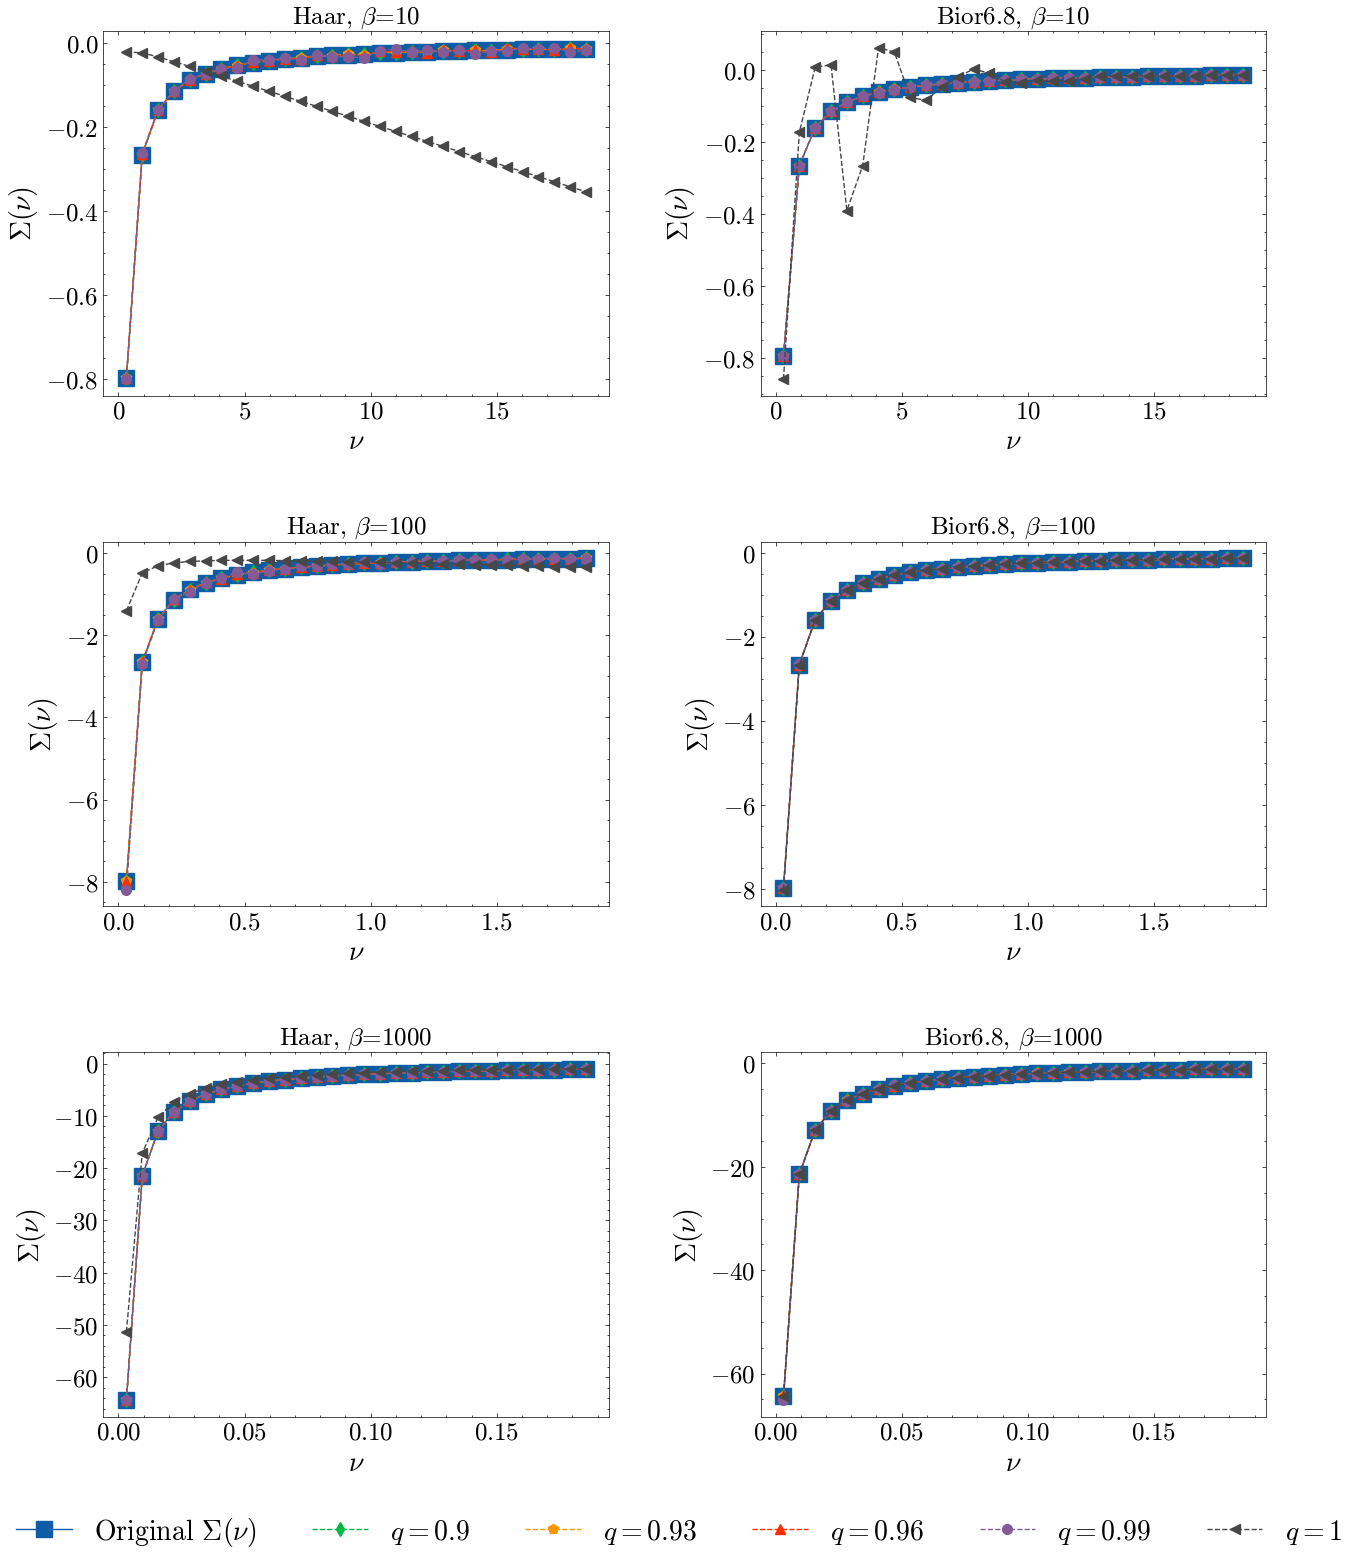

In [32]:
# plot
fig, axs = plt.subplots(3, 2, figsize=(15,18), gridspec_kw={'hspace': 0.4, 'wspace':0.3})

markers = ['s', 'd', 'p', '^', 'o', '<', '>', 'x', '*', '+']

for bidx, basis in enumerate(bases):
    for beta_idx, beta in enumerate(betas):
        for t_idx, thresh in enumerate(threshold_quantiles):
            pltdata = data.loc[(data["basis"]==basis) & (data["beta"]==beta) & (data["threshold_quantile"]==thresh)]
            niw=30
            nu = (2*np.arange(niw) + 1)*np.pi/beta
            if thresh==0:
                axs[beta_idx, bidx].plot(nu, pltdata["selfenergy"].to_numpy()[0].imag[niwf:niwf+niw], marker=markers[t_idx], ms=12, label=r"Original $\Sigma(\nu)$")
            else:
                axs[beta_idx, bidx].plot(nu, pltdata["selfenergy"].to_numpy()[0].imag[niwf:niwf+niw], marker=markers[t_idx], ls="--", ms=7, label=rf"$q=${thresh}")
            axs[beta_idx, bidx].set_xlabel(r"$\nu$")
            axs[beta_idx, bidx].set_ylabel(r"$\Sigma(\nu)$")
            axs[beta_idx, bidx].set_title(rf"{basis.capitalize()}, $\beta$={beta}")
axs[beta_idx, bidx].legend(ncol=len(threshold_quantiles), bbox_to_anchor=(1.2, -0.2), prop={'size':20})

        

# Preservation of centrosymmetry

In [33]:
# helper functions for error metrics
def rmse(x, y):
    return np.sqrt(np.mean((x-y)**2))

def rel_err(x,y):
    return np.mean(np.abs(x-y)/np.abs(x))

# generates the green triangle
def top_enclosed_matrix(matrix):
    # Check if the matrix is square
    if matrix.shape[0] != matrix.shape[1]:
        raise ValueError('The input matrix should be square.')

    size = matrix.shape[0]

    # Initialize new_matrix as a complex-valued array
    new_matrix = np.zeros((size, size), dtype=complex)

    count = 0
    for i in range(size):
        for j in range(size):
            # Conditions for top area enclosed by main diagonal and antidiagonal
            if i + j < size and i <= j:
                count += 1
                new_matrix[i, j] = matrix[i, j]
                
    return new_matrix

# takes green and produces yellow & green
def mirror_anti_diagonal_conj(matrix):
    # Check that the input is a 2D square matrix
    assert matrix.ndim == 2, "The input matrix must be a 2D array"
    assert matrix.shape[0] == matrix.shape[1], "The input matrix must be square"

     # Create a copy of the original matrix
    mirrored_matrix = np.copy(matrix)
    
    # Get the size of the matrix
    n = matrix.shape[0]
    
    # Iterate through the matrix
    for i in range(n):
        for j in range(n-i-1):  # exclude the anti-diagonal by subtracting 1
            # Mirror the element and take the complex conjugate
            mirrored_matrix[n-1-j,n-1-i] = np.conj(matrix[i,j])
            
    return mirrored_matrix

# takes yellow and green and produces fully unfolded matrix
def mirror_upper_to_lower(matrix):
    # Check that the input is a 2D square matrix
    assert matrix.ndim == 2, "The input matrix must be a 2D array"
    assert matrix.shape[0] == matrix.shape[1], "The input matrix must be square"

    # Copy the input matrix to avoid altering the original one
    mirrored_matrix = matrix.copy()

    # Mirror the upper triangular matrix
    i_lower = np.tril_indices(matrix.shape[0], -1)
    mirrored_matrix[i_lower] = mirrored_matrix.T[i_lower]

    return mirrored_matrix

# function for full unfolding
def reconstruct_symmetries(X):
    return mirror_upper_to_lower(mirror_anti_diagonal_conj(top_enclosed_matrix(X)))

In [34]:
# params
betas = np.array([10,100,1000])
threshold_quantiles = np.array([0.9,.91,.92,0.93,.94,0.95,0.96,0.97,0.98,0.99])
niwf = 256
u = 1
bases = ['haar', "bior4.4"]

In [40]:
data = pd.DataFrame(
                columns=['basis', 'beta', 'threshold_quantile', 'mse_charge_sym', 'mse_charge_so', 'mse_charge_ro',
                         'mse_spin_sym', 'mse_spin_so', 'mse_spin_ro', 'ssim_charge', 'ssim_spin'])

for basis in bases:
    print(f"BASIS: {basis.capitalize()}")
    level = np.min([6, pywt.dwt_max_level(niwf, basis)])
    for bidx, beta in enumerate(betas):
        print(f"    Starting calculation for beta={beta}")
        chi_spin = al.chi_s(u, beta, u/2, niwf).real
        chi_charge = al.chi_c(u, beta, u/2, niwf).real
        
        for tidx, threshold_quantile in enumerate(threshold_quantiles):
            print(f"        Calculating for threshold quantile q={threshold_quantile}")
                
            a = np.int32(niwf/(2**(level-1)))

            coeffs_c = pywt.wavedec2(chi_charge,basis,level=level)
            coeff_c_arr,coeff_c_slices = pywt.coeffs_to_array(coeffs_c)

            coeffs_s = pywt.wavedec2(chi_spin,basis,level=level)
            coeff_s_arr,coeff_s_slices = pywt.coeffs_to_array(coeffs_s)

            c_details = np.concatenate((coeff_c_arr[a:,:].flatten(), coeff_c_arr[:a,a:].flatten()))
            s_details = np.concatenate((coeff_s_arr[a:,:].flatten(), coeff_s_arr[:a,a:].flatten()))

            thresh_c = np.quantile(np.abs(c_details), threshold_quantile)
            thresh_s = np.quantile(np.abs(s_details), threshold_quantile)

            approx_c = np.copy(coeff_c_arr[:a,:a])
            coeff_c_arr_rec = compare(coeff_c_arr[:,:], thresh_c)*coeff_c_arr 
            coeff_c_arr_rec[:a,:a] = np.copy(approx_c)

            approx_s = np.copy(coeff_s_arr[:a,:a])
            coeff_s_arr_rec = compare(coeff_s_arr[:,:], thresh_s) * coeff_s_arr 
            coeff_s_arr_rec[:a,:a] = np.copy(approx_s)

            chi_charge_rec = pywt.waverec2(pywt.array_to_coeffs(coeff_c_arr_rec,coeff_c_slices,output_format='wavedec2'),basis)
            chi_spin_rec   = pywt.waverec2(pywt.array_to_coeffs(coeff_s_arr_rec,coeff_s_slices,output_format='wavedec2'),basis)

            chi_charge_rec_sym = reconstruct_symmetries(chi_charge_rec)
            chi_spin_rec_sym = reconstruct_symmetries(chi_spin_rec)

            # compute metrics
            mse_charge_sym = rmse(chi_charge_rec, chi_charge_rec_sym) 
            mse_spin_sym = rmse(chi_spin_rec, chi_spin_rec_sym) 
            
            mse_charge_sym2 = rmse(chi_charge, chi_charge_rec_sym) 
            mse_spin_sym2 = rmse(chi_spin, chi_spin_rec_sym) 

            mse_charge_og = rmse(chi_charge, chi_charge_rec) 
            mse_spin_og = rmse(chi_spin, chi_spin_rec) 

            ssim_c = ssim(chi_charge_rec, chi_charge_rec_sym, data_range=255, gaussian_weights=True, sigma=1.5, use_sample_covariance=False)
            ssim_s = ssim(chi_spin_rec, chi_spin_rec_sym, data_range=255, gaussian_weights=True, sigma=1.5, use_sample_covariance=False)

            new_data = pd.DataFrame([[basis,
                                    beta,
                                    threshold_quantile,
                                    mse_charge_sym,
                                    mse_charge_sym2,
                                    mse_charge_og,
                                    mse_spin_sym,
                                    mse_spin_sym2,
                                    mse_spin_og,
                                    ssim_c,
                                    ssim_s
                                    ]], columns=data.columns)
            
            data = pd.concat([data, new_data], ignore_index=True)

BASIS: Haar
    Starting calculation for beta=10
        Calculating for threshold quantile q=0.9


/Users/eminmoghadas/anaconda3/envs/waves/lib/python3.11/site-packages/skimage/metrics/_structural_similarity.py:220: ComplexWarning: Casting complex values to real discards the imaginary part
  im2 = im2.astype(float_type, copy=False)


        Calculating for threshold quantile q=0.91
        Calculating for threshold quantile q=0.92
        Calculating for threshold quantile q=0.93
        Calculating for threshold quantile q=0.94
        Calculating for threshold quantile q=0.95
        Calculating for threshold quantile q=0.96
        Calculating for threshold quantile q=0.97
        Calculating for threshold quantile q=0.98
        Calculating for threshold quantile q=0.99
    Starting calculation for beta=100
        Calculating for threshold quantile q=0.9
        Calculating for threshold quantile q=0.91
        Calculating for threshold quantile q=0.92
        Calculating for threshold quantile q=0.93
        Calculating for threshold quantile q=0.94
        Calculating for threshold quantile q=0.95
        Calculating for threshold quantile q=0.96
        Calculating for threshold quantile q=0.97
        Calculating for threshold quantile q=0.98
        Calculating for threshold quantile q=0.99
    Starting 

In [41]:
# store df
data.to_pickle("./data/sym_data.pkl")

/Users/eminmoghadas/anaconda3/envs/waves/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


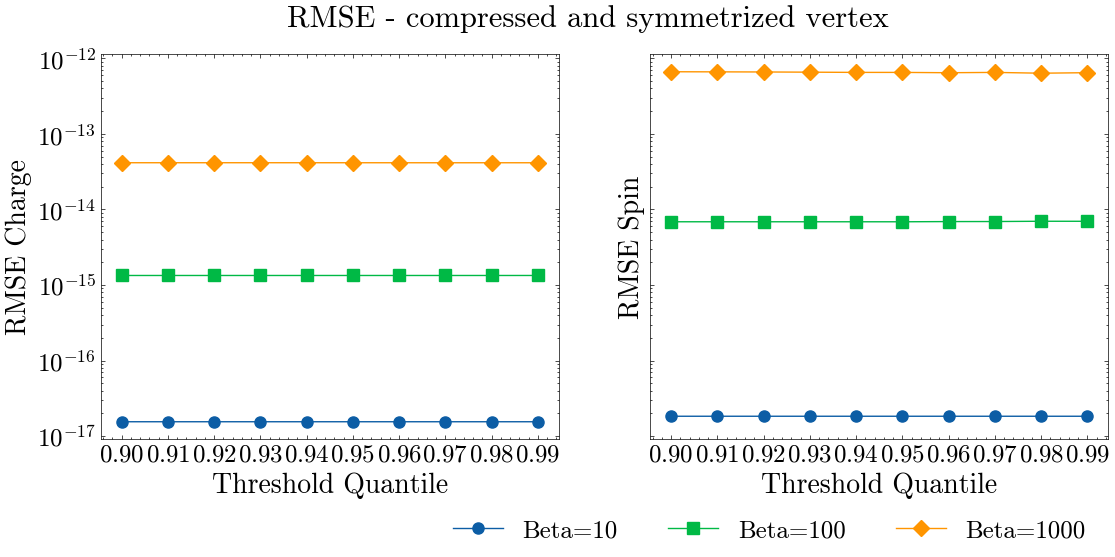

In [42]:
# load data
df = pd.read_pickle("./data/sym_data.pkl")

# Create a figure and an axis for the plot.
fig, ax = plt.subplots(1,2, figsize=(13,5), sharey=True)

# Define markers for different betas.
markers = ['o', 's', 'D'] # Circle, square, diamond.

# Plot a line for each beta value.
for beta, marker in zip(betas, markers):
    temp_df = df[(df['beta'] == beta) & (df['basis']=='haar')]
    ax[0].plot(temp_df['threshold_quantile'], temp_df['mse_charge_sym'], marker=marker, label=f'Beta={beta}')
    ax[1].plot(temp_df['threshold_quantile'], temp_df['mse_spin_sym'], marker=marker, label=f'Beta={beta}')

# Adding labels and title.
ax[0].set_xlabel('Threshold Quantile')
ax[1].set_xlabel('Threshold Quantile')
ax[0].set_ylabel('RMSE Charge')
ax[1].set_ylabel('RMSE Spin')

# Set the y-axis to be logarithmic.
ax[0].set_yscale('log')
ax[1].set_yscale('log')

ax[0].set_xticks(threshold_quantiles)
ax[1].set_xticks(threshold_quantiles)

ax[1].legend(bbox_to_anchor=(1, -0.15), ncol=3)

# Show the plot.
plt.suptitle("RMSE - compressed and symmetrized vertex")
plt.savefig('graphics/symmetry_rec.pdf', bbox_inches='tight')

/Users/eminmoghadas/anaconda3/envs/waves/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


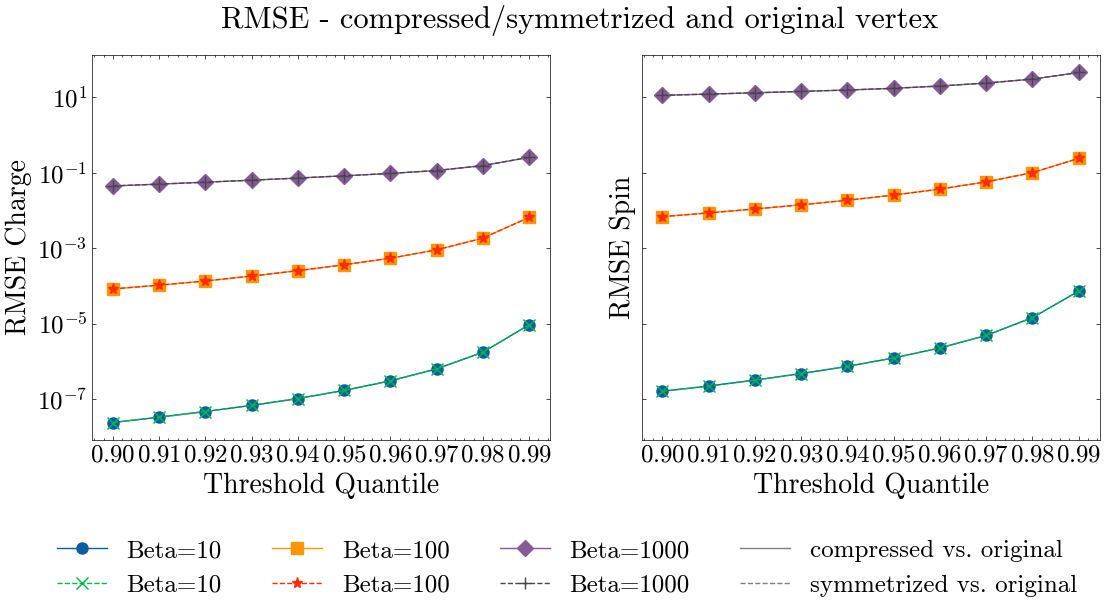

In [43]:
# Create a figure and an axis for the plot.
fig, ax = plt.subplots(1,2, figsize=(13,5), sharey=True)

# Define markers for different betas.
markers = ['o', 's', 'D'] # Circle, square, diamond.
markers2 = ['x', '*', '+']

# Plot a line for each beta value.
for beta, marker, marker2 in zip(betas, markers, markers2):
    temp_df = df[(df['beta'] == beta) & (df['basis']=='haar')]
    #color = next(ax[0]._get_lines.prop_cycler)['color']
    ax[0].plot(temp_df['threshold_quantile'], temp_df['mse_charge_so'], marker=marker, label=f'Beta={beta}')
    ax[0].plot(temp_df['threshold_quantile'], temp_df['mse_charge_ro'], marker=marker2, ls="--", label=f'Beta={beta}')
    ax[1].plot(temp_df['threshold_quantile'], temp_df['mse_spin_so'], marker=marker, label=f'Beta={beta}')
    ax[1].plot(temp_df['threshold_quantile'], temp_df['mse_spin_ro'], marker=marker2, ls="--", label=f'Beta={beta}')

# Adding labels and title.
ax[0].set_xlabel('Threshold Quantile')
ax[1].set_xlabel('Threshold Quantile')
ax[0].set_ylabel('RMSE Charge')
ax[1].set_ylabel('RMSE Spin')

# Set the y-axis to be logarithmic.
ax[0].set_yscale('log')
ax[1].set_yscale('log')

ax[0].set_xticks(threshold_quantiles)
ax[1].set_xticks(threshold_quantiles)

# Additional legend entries for spin/charge differentiation
ax[1].plot([], [], color='grey', linestyle='-', label='compressed vs. original') 
ax[1].plot([], [], color='grey', linestyle='--', label='symmetrized vs. original') 

ax[1].legend(bbox_to_anchor=(1, -0.2), ncol=4)

# Show the plot.
plt.suptitle("RMSE - compressed/symmetrized and original vertex")
plt.savefig('graphics/symmetry_og.pdf', bbox_inches='tight')

In [56]:
# one example of symmetry analysis
beta=1000
q=0.99
u=1
niwf=256
level=6
wl_basis = 'haar'

chi_spin = al.chi_s(u, beta, u/2, niwf).real

a = np.int32(niwf/(2**(level-1)))

coeffs_s = pywt.wavedec2(chi_spin,wl_basis,level=level)
coeff_s_arr,coeff_s_slices = pywt.coeffs_to_array(coeffs_s)

s_details = np.concatenate((coeff_s_arr[a:,:].flatten(), coeff_s_arr[:a,a:].flatten()))

thresh_s = np.quantile(np.abs(s_details), q)

approx_s = np.copy(coeff_s_arr[:a,:a])
coeff_s_arr_rec = compare(coeff_s_arr, thresh_s) * coeff_s_arr
coeff_s_arr_rec[:a,:a] = np.copy(approx_s)

chi_rec = pywt.waverec2(pywt.array_to_coeffs(coeff_s_arr_rec,coeff_s_slices,output_format='wavedec2'),wl_basis)

chi_rec_sym = reconstruct_symmetries(chi_rec) 

ssim_score = ssim(chi_rec.real, chi_rec_sym.real, data_range=255, gaussian_weights=True, sigma=1.5, use_sample_covariance=False)
print(f"SSIM = {ssim_score}")

SSIM = 0.9999999999999893


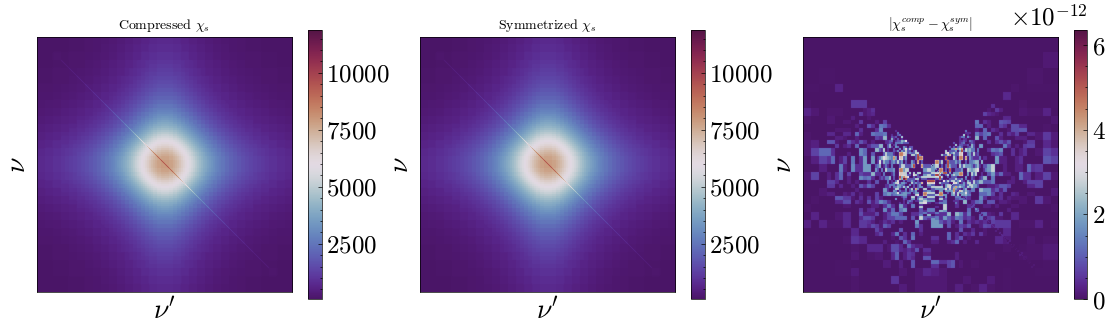

In [57]:
# plot example
fig, axs = plt.subplots(1,3, figsize=(14,5))

im = axs[0].imshow(chi_rec.real, cmap=tl_resc)
plt.colorbar(im, ax=axs[0], shrink=0.7)
axs[0].set_title(r"Compressed $\chi_s$", fontsize=10)

im = axs[1].imshow(chi_rec_sym.real, cmap=tl_resc)
plt.colorbar(im, ax=axs[1], shrink=0.7)
axs[1].set_title(r"Symmetrized $\chi_s$", fontsize=10)

im = axs[2].imshow(np.abs(chi_rec.real-chi_rec_sym.real), cmap=tl_resc)
plt.colorbar(im, ax=axs[2], shrink=0.7)
axs[2].set_title(r"$|\chi^{comp}_s-\chi^{sym}_s|$", fontsize=10)

for ax in axs:
    ax.set_xticks([]) # remove ticks
    ax.set_yticks([])

    ax.set_xlabel(r"$\nu'$")
    ax.set_ylabel(r"$\nu$")

plt.savefig(f"graphics/{wl_basis}_err_ex.pdf", bbox_inches="tight")

In [47]:
# comparison with qmc data
import correl.w2dyn_post as w5

# read all hdf5 files with 2-partice calculations for U sweep
F = []
os.chdir("./qmc_data/")
path = os.getcwd()
for file in os.listdir(path):
    if os.path.isfile(path+"/"+file):
        F.append(w5.read(path+"/"+file))
os.chdir("./../")

# sort according to U
F.sort(key=lambda x : x.beta())

In [48]:
# symmetry analysis for QMC
sym_rmse = []
betas = []
for f in F:
    betas.append(f.beta())

    chi = f.chi_stat().c.real

    chi_rec = reconstruct_symmetries(chi)

    sym_rmse.append(rmse(chi_rec.real, chi))

In [49]:
# save qmc data
np.savez("./data/qmc_data", betas=betas, qmc_rmse=sym_rmse)

# test loading the file
npzfile = np.load("./data/qmc_data.npz")
betas = npzfile['betas']
sym_rmse = npzfile['qmc_rmse']

In [50]:
# comparison with QMC - along beta values
niwf = 256
u = 1
beta = np.linspace(10, 300, 10)
threshold_quantile = 0.99
level = 6
basis="haar"

data = pd.DataFrame(columns=['beta', 'rmse_charge', 'rmse_spin'])

for idx, b in enumerate(beta, start=1):
    print(f"Calculation for beta {idx} / {len(beta)}")

    chi_spin = al.chi_s(u, b, u/2, niwf).real
    chi_charge = al.chi_c(u, b, u/2, niwf).real

    a = np.int32(niwf/(2**(level-1)))

    coeffs_c = pywt.wavedec2(chi_charge,basis,level=level)
    coeff_c_arr,coeff_c_slices = pywt.coeffs_to_array(coeffs_c)

    coeffs_s = pywt.wavedec2(chi_spin,basis,level=level)
    coeff_s_arr,coeff_s_slices = pywt.coeffs_to_array(coeffs_s)

    c_details = np.concatenate((coeff_c_arr[a:,:].flatten(), coeff_c_arr[:a,a:].flatten()))
    s_details = np.concatenate((coeff_s_arr[a:,:].flatten(), coeff_s_arr[:a,a:].flatten()))

    thresh_c = np.quantile(np.abs(c_details), threshold_quantile)
    thresh_s = np.quantile(np.abs(s_details), threshold_quantile)

    approx_c = np.copy(coeff_c_arr[:a,:a])
    coeff_c_arr_rec = compare(coeff_c_arr[:,:], thresh_c)*coeff_c_arr 
    coeff_c_arr_rec[:a,:a] = np.copy(approx_c)

    approx_s = np.copy(coeff_s_arr[:a,:a])
    coeff_s_arr_rec = compare(coeff_s_arr[:,:], thresh_s) * coeff_s_arr 
    coeff_s_arr_rec[:a,:a] = np.copy(approx_s)

    chi_charge_rec = pywt.waverec2(pywt.array_to_coeffs(coeff_c_arr_rec,coeff_c_slices,output_format='wavedec2'),basis)
    chi_spin_rec   = pywt.waverec2(pywt.array_to_coeffs(coeff_s_arr_rec,coeff_s_slices,output_format='wavedec2'),basis)

    chi_charge_rec_sym = reconstruct_symmetries(chi_charge_rec)
    chi_spin_rec_sym = reconstruct_symmetries(chi_spin_rec)

    # compute metrics
    rmse_charge_sym = rmse(chi_charge_rec, chi_charge_rec_sym) 
    rmse_spin_sym = rmse(chi_spin_rec, chi_spin_rec_sym) 

    new_data = pd.DataFrame([[b,
                            rmse_charge_sym,
                            rmse_spin_sym
                            ]], columns=data.columns)
    
    data = pd.concat([data, new_data], ignore_index=True)

    

Calculation for beta 1 / 10
Calculation for beta 2 / 10
Calculation for beta 3 / 10
Calculation for beta 4 / 10
Calculation for beta 5 / 10
Calculation for beta 6 / 10
Calculation for beta 7 / 10
Calculation for beta 8 / 10
Calculation for beta 9 / 10
Calculation for beta 10 / 10


In [51]:
# store df
data.to_pickle("./data/sym_qmc.pkl")

/Users/eminmoghadas/anaconda3/envs/waves/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


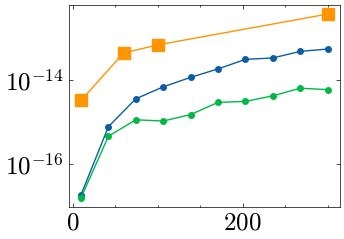

In [52]:
#plot with qmc results
plt.plot(beta, data['rmse_spin'], ".-")
plt.plot(beta, data['rmse_charge'], ".-")
plt.plot(betas, sym_rmse, "s-")
plt.yscale('log')